Example notebook training a flow on samples from a known distribution, then using rejection sampling to generate new samples

In [1]:
import os
import sys
import argparse
import logging
import torch
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from scipy.stats import multivariate_normal

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [4]:
from nnest import NestedSampler, MCMCSampler
from nnest.trainer import Trainer
from nnest.likelihoods import *
from nnest.priors import *
from nnest.distributions import GeneralisedNormal

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
def plot_flow(samples, model):
    x_synth = model.netG.sample(samples.size).detach().cpu().numpy()
    z = model.get_latent_samples(samples)
    grid = []
    for x in np.linspace(np.min(samples[:, 0]) - 1, np.max(samples[:, 0]) + 1, 10):
        for y in np.linspace(np.min(samples[:, 1]) - 1, np.max(samples[:, 1]) + 1, 5000):
            grid.append([x, y])
    for y in np.linspace(np.min(samples[:, 1]) - 1, np.max(samples[:, 1]) + 1, 10):
        for x in np.linspace(np.min(samples[:, 0]) - 1, np.max(samples[:, 0]) + 1, 5000):
            grid.append([x, y])
    grid = np.array(grid)
    z_grid = model.get_latent_samples(grid)
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].scatter(grid[:, 0], grid[:, 1], c=grid[:, 0], marker='.', s=1, linewidths=0)
    ax[0].scatter(samples[:, 0], samples[:, 1], s=4)
    ax[0].set_title('Real data')
    ax[1].scatter(z_grid[:, 0], z_grid[:, 1], c=grid[:, 0], marker='.', s=1, linewidths=0)
    ax[1].scatter(z[:, 0], z[:, 1], s=4)
    ax[1].set_title('Latent data')
    ax[2].scatter(x_synth[:, 0], x_synth[:, 1], s=2)
    ax[2].set_title('Synthetic data')
    plt.tight_layout()
    plt.show()
    # Plot grid warp
    plt.figure(figsize=(6,6))
    ng = 30
    xx, yy = np.linspace(-4,4, ng), np.linspace(-4,4, ng)
    xv, yv = np.meshgrid(xx, yy)
    xy = np.stack([xv, yv], axis=-1)
    in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3
    xy = xy.reshape((ng*ng, 2))
    xy = torch.from_numpy(xy.astype(np.float32))
    xs = model.get_samples(xy)
    xs = xs.reshape((ng, ng, 2))
    p1 = np.reshape(xs[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(xs[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    p1 = np.reshape(xs[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(xs[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    plt.gca().add_collection(lcy)
    plt.gca().add_collection(lcx)
    plt.xlim([np.min(samples[:,0])-0.05,np.max(samples[:,0])+0.05])
    plt.ylim([np.min(samples[:,1])-0.05,np.max(samples[:,1])+0.05])
    plt.scatter(samples[:,0], samples[:,1], c='r', s=5, alpha=0.5)
    plt.show()

In [36]:
def test_rejection(like, prior, model, num_samples=1000, nested_fraction=0.01):
    np.random.seed(0)
    init_samples, loglstar = like.uniform_sample(prior, 1000, nested_fraction)
    model.train(init_samples, jitter=0.001, max_iters=2000)
    plot_flow(init_samples, model)
    sampler = MCMCSampler(like.x_dim, like, prior=prior, trainer=model, log_level=logging.INFO)
    samples = np.empty((num_samples, like.x_dim))
    ncalls = np.zeros(num_samples)
    for i in range(samples.shape[0]):
        results = sampler._rejection_sample(init_samples, loglstar, cache=True)
        sample, derived_sample, loglike, ncall = results
        samples[i, :] = sample[0, :]
        ncalls[i] = ncall
    print(np.mean(ncalls))
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    flat_samples = samples.reshape((-1, like.x_dim))
    ax[0].scatter(flat_samples[:,0], flat_samples[:,1], c='r', s=5, alpha=0.5)
    plt.show()

In [8]:
like = Gaussian(2, 0.9)
prior = UniformPrior(2, -5, 5)

[nnest.trainer] [INFO] SingleSpeedCholeksy(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): Choleksy()
    )
  )
)
[nnest.trainer] [INFO] Number of network params: [5]
[nnest.trainer] [INFO] Device [cpu]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0010]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0202] validation loss [0.0204]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0123] validation loss [0.0127]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0082] validation loss [0.0089]
[nnest.trainer] [INFO] Epoch [300] train loss [0.0061] validation loss [0.0069]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0048] validation loss [0.0056]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0040] validation loss [0.0048]
[nnest.trainer] [INFO] Epoch [600] train loss [0.0036] validation loss [0.0043]
[nnest.trainer] [INFO] Epoch [700] train loss [0.0034] validation loss [0.0041]
[nnest.trainer] [INFO] Epoch [800] tra

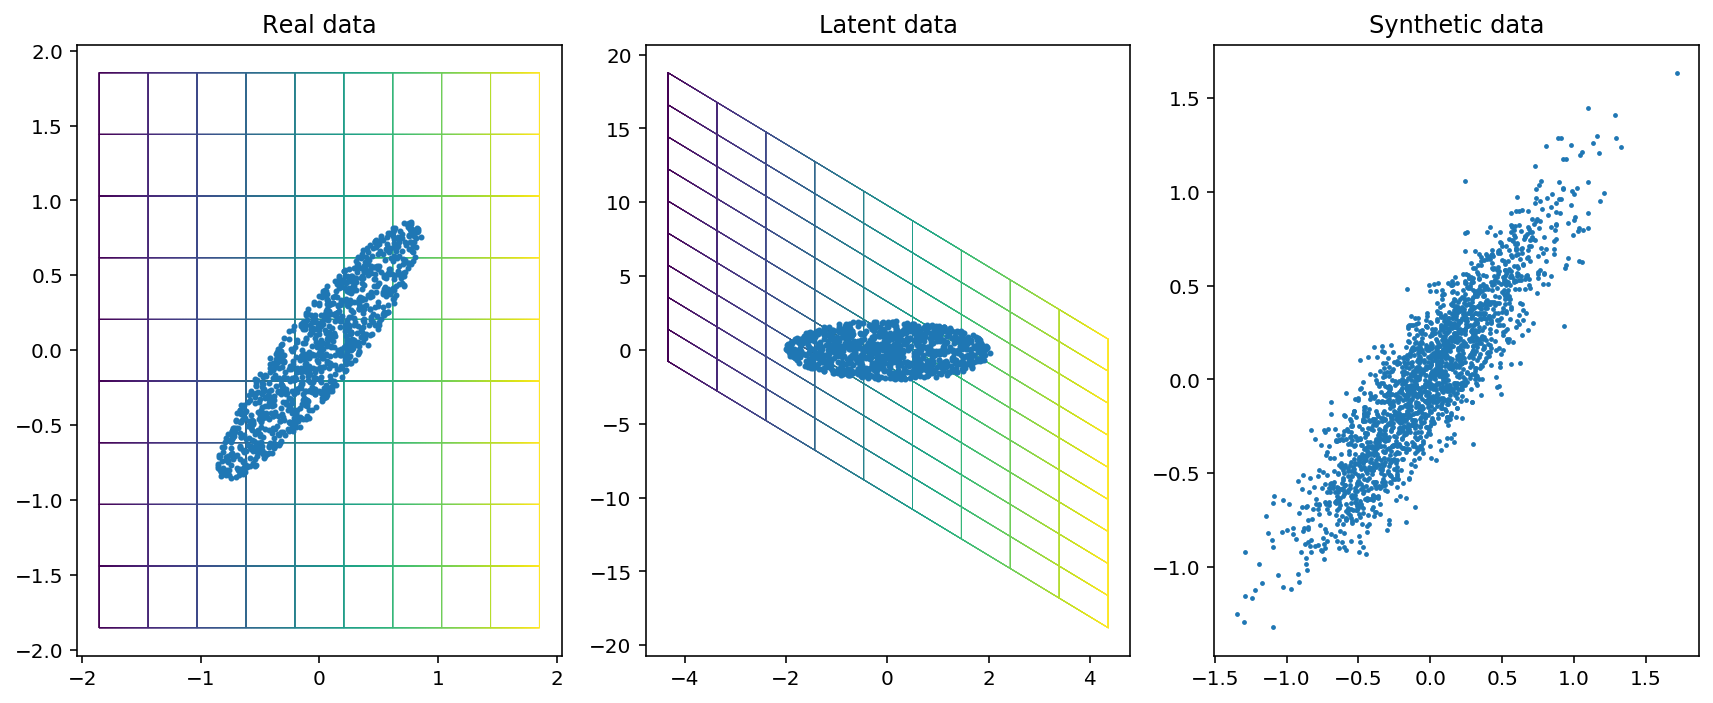

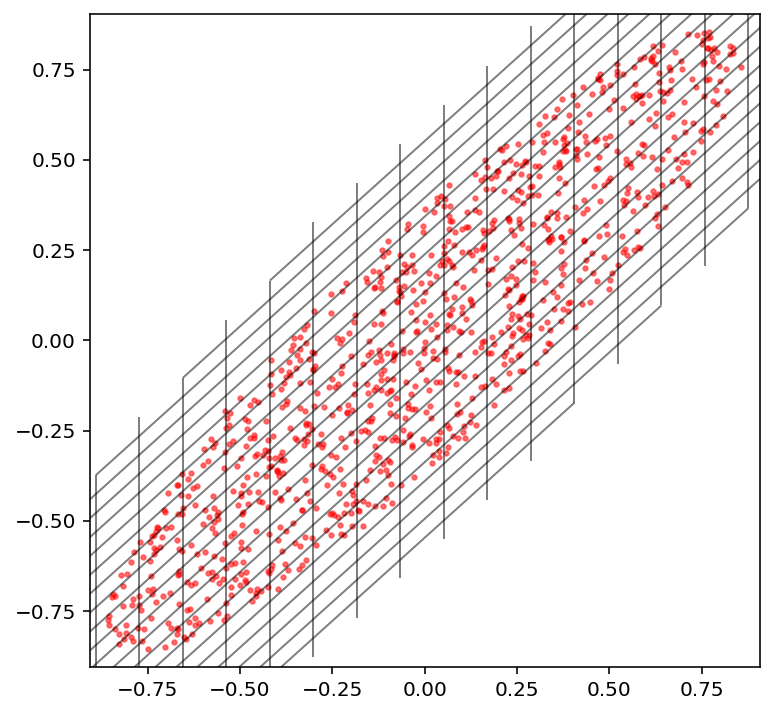

Creating directory for new run logs/test/run341
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
1.293


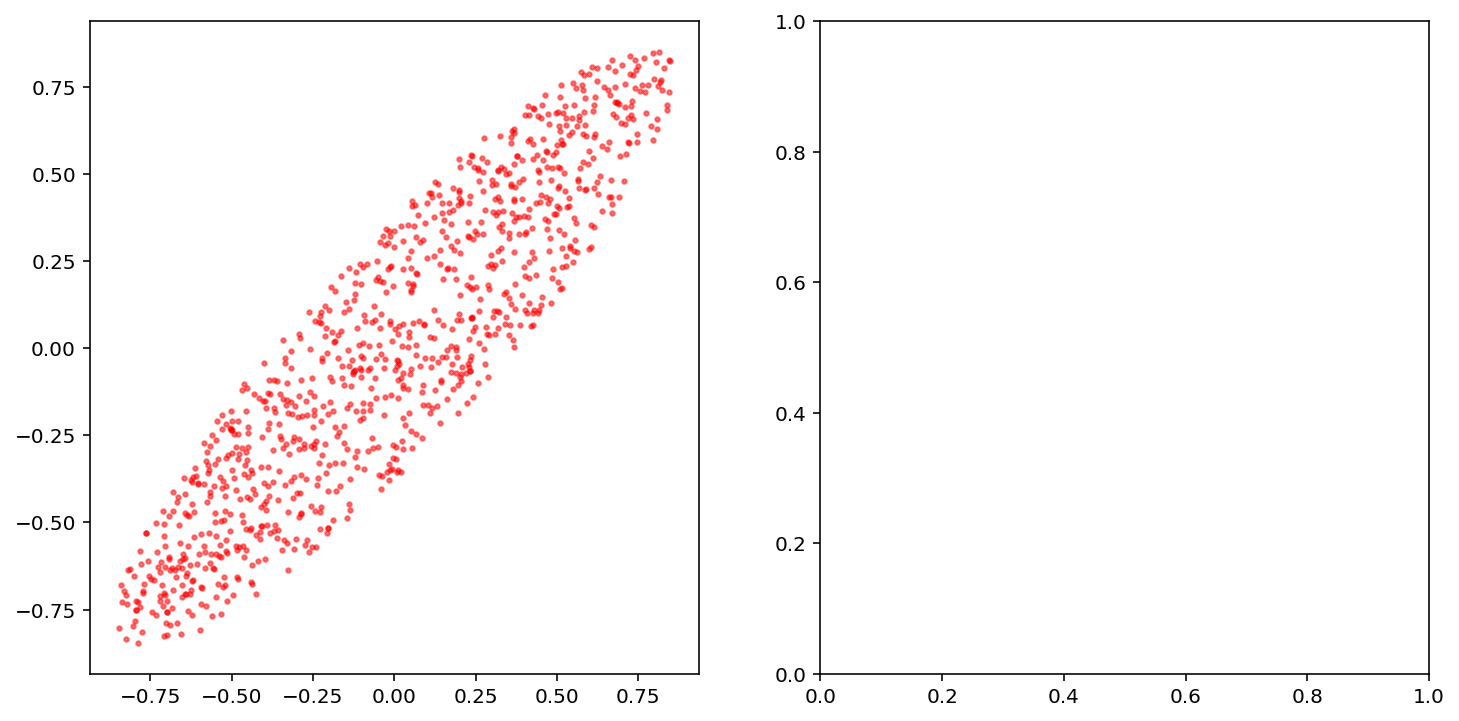

In [9]:
model = Trainer(like.x_dim, flow='choleksy', learning_rate=0.001)
test_rejection(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedNVP(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): Tanh()
          (6): Linear(in_features=64, out_features=2, bias=True)
        )
        (translate_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): ReLU()
          (6): Linear(in_features=64, out_features=2, bias=True)
        )
      )
      (1): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
     

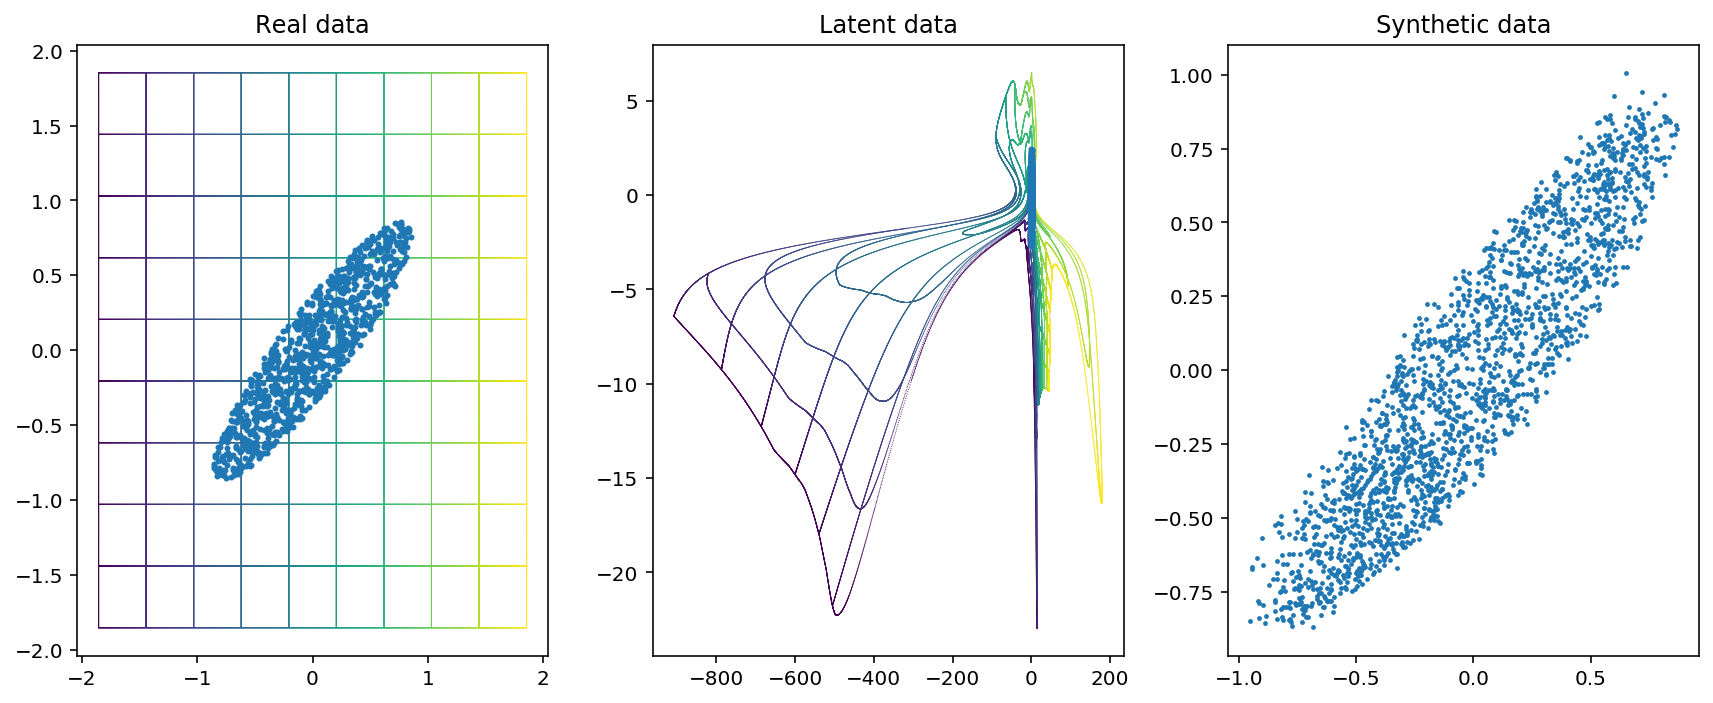

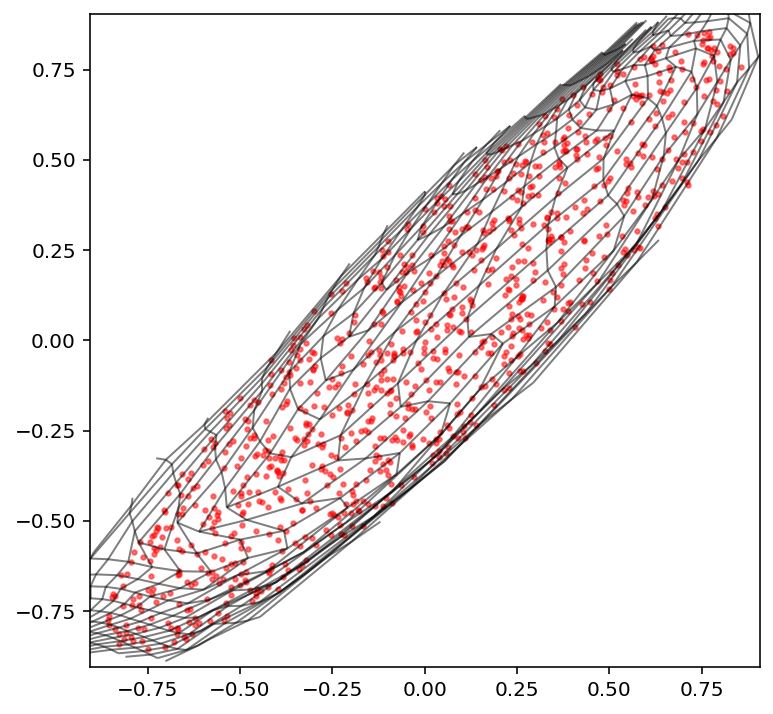

Creating directory for new run logs/test/run342
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
1.178


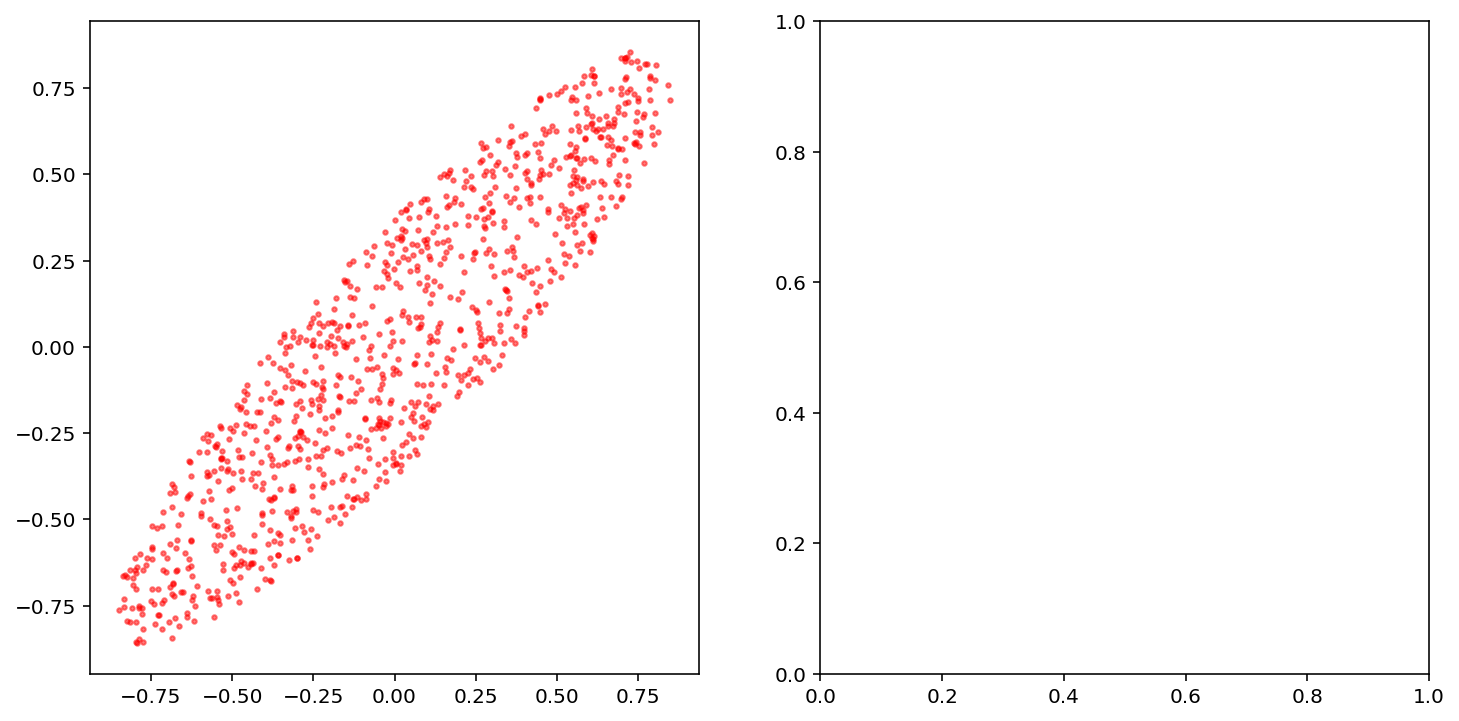

In [10]:
model = Trainer(like.x_dim, hidden_dim=64, num_blocks=5, flow='nvp', learning_rate=0.001)
test_rejection(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

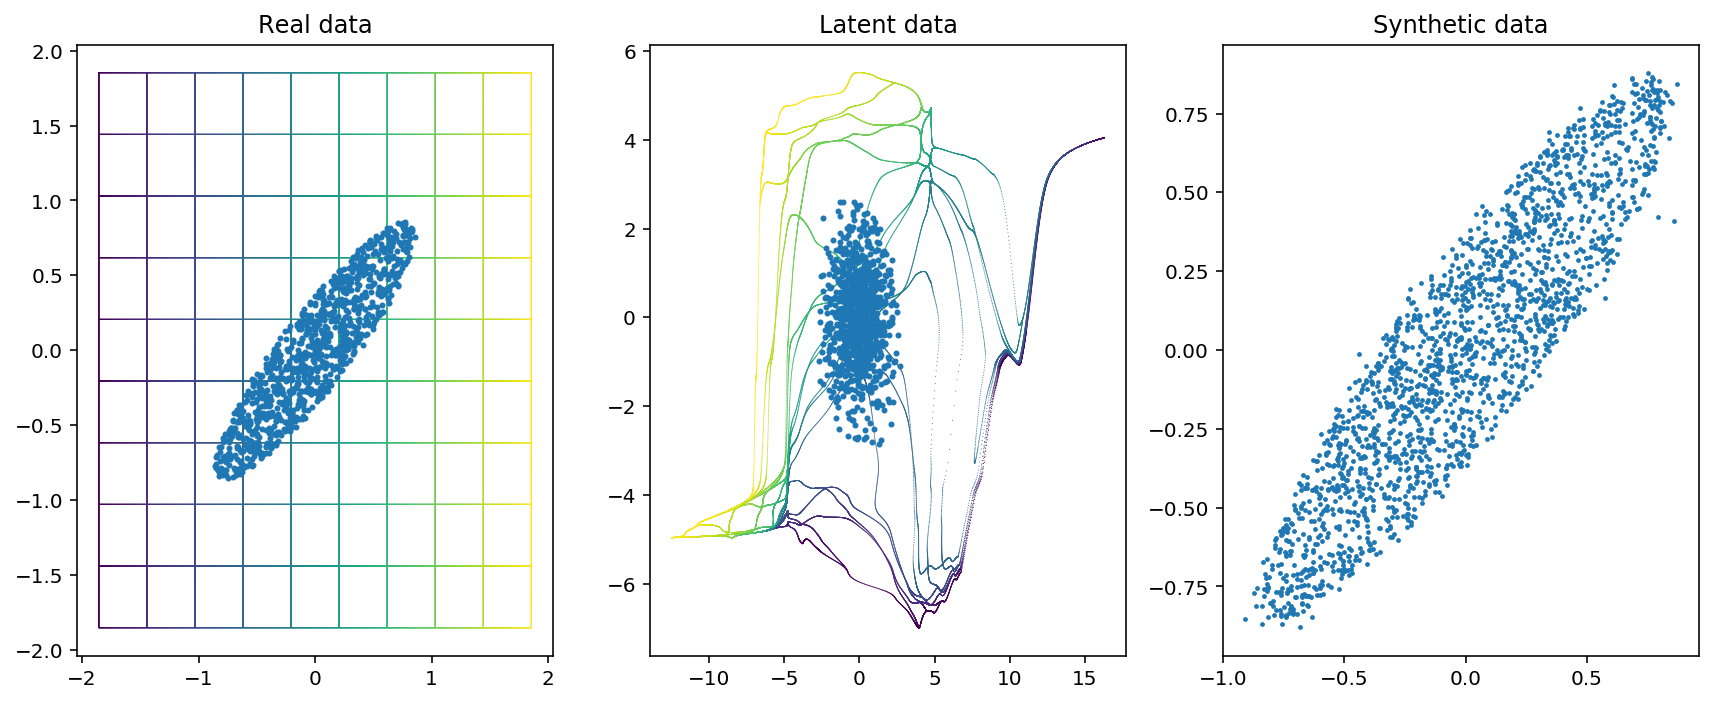

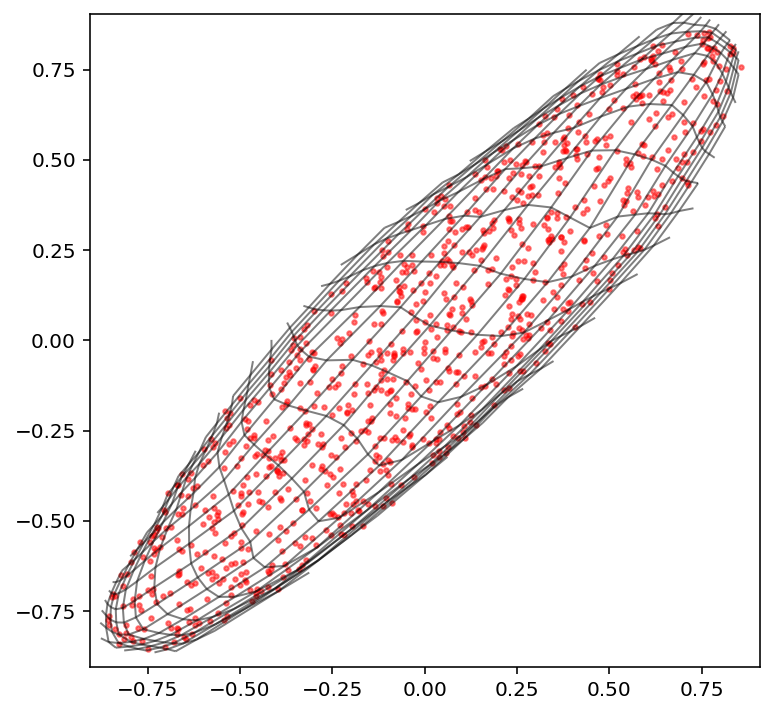

Creating directory for new run logs/test/run343
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
1.189


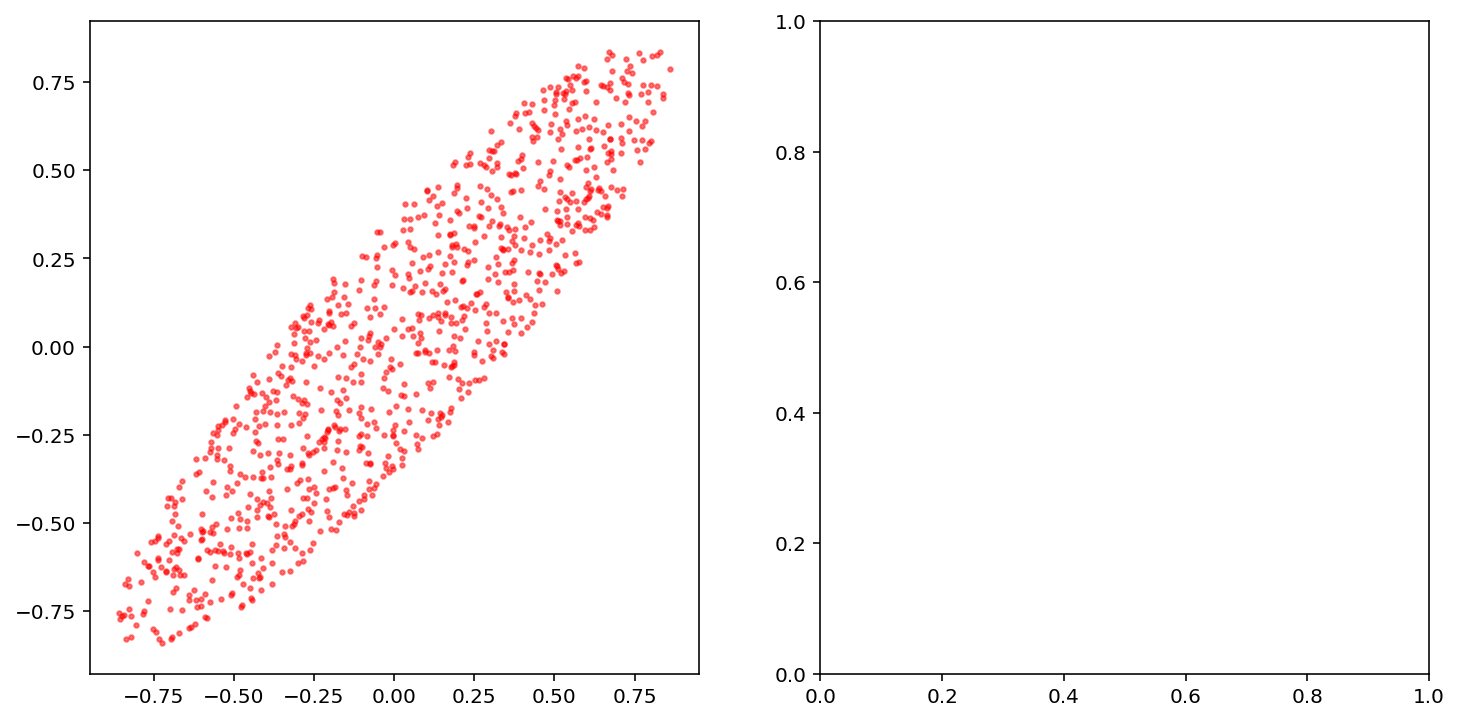

In [11]:
model = Trainer(like.x_dim, flow='spline', learning_rate=0.001)
test_rejection(like, prior, model)

In [12]:
like = Himmelblau(2)
prior = UniformPrior(2, -5, 5)

[nnest.trainer] [INFO] SingleSpeedCholeksy(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): Choleksy()
    )
  )
)
[nnest.trainer] [INFO] Number of network params: [5]
[nnest.trainer] [INFO] Device [cpu]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0010]
[nnest.trainer] [INFO] Epoch [1] train loss [0.1008] validation loss [0.1018]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0578] validation loss [0.0594]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0502] validation loss [0.0512]
[nnest.trainer] [INFO] Epoch [300] train loss [0.0487] validation loss [0.0495]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0485] validation loss [0.0491]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0485] validation loss [0.0491]
[nnest.trainer] [INFO] Epoch [600] train loss [0.0485] validation loss [0.0491]
[nnest.trainer] [INFO] Epoch [662] ran out of patience
[nnest.trainer] [INFO] Best epoch [612] validation loss [0.0491

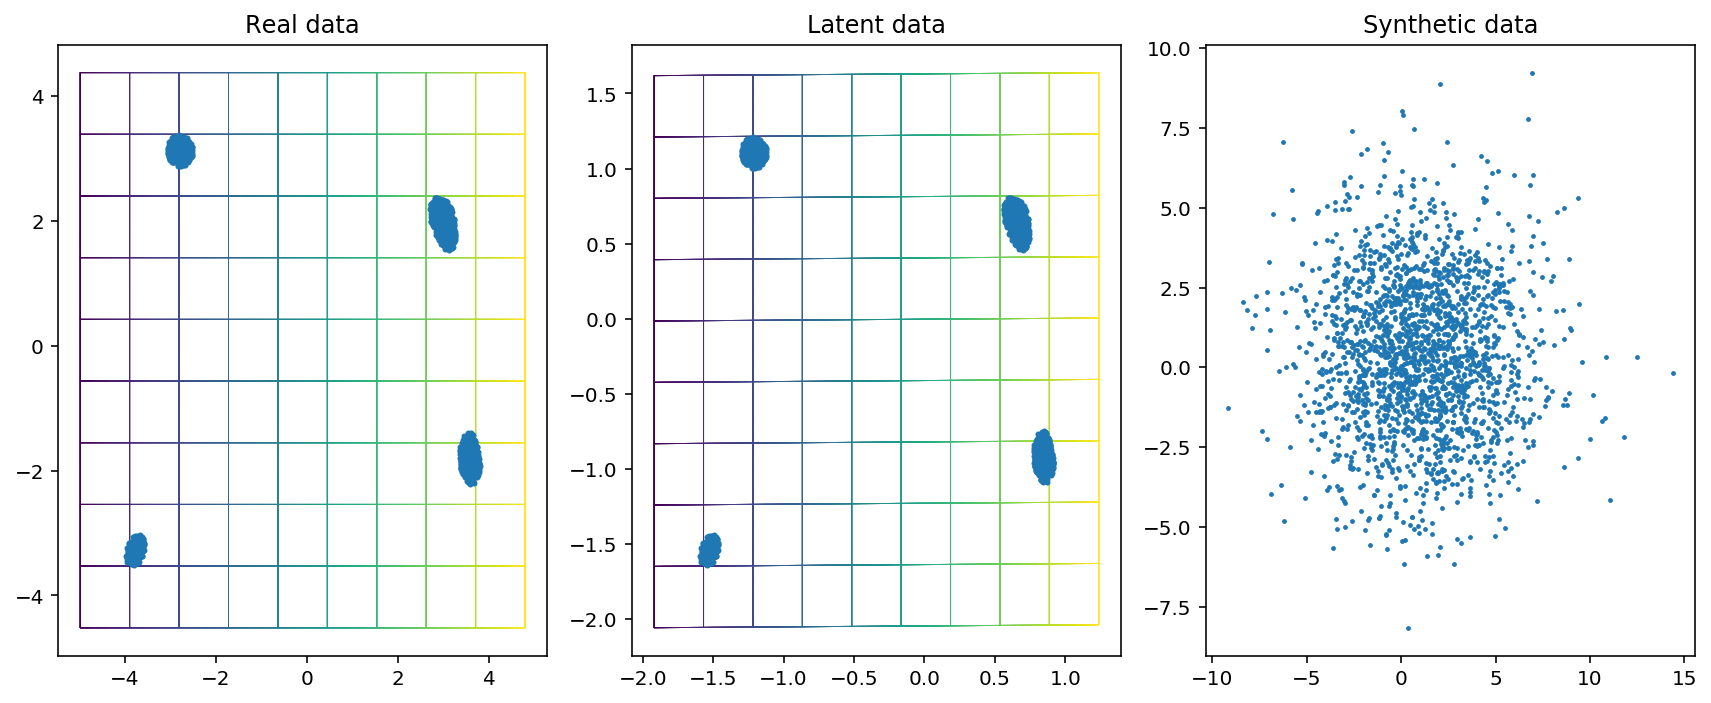

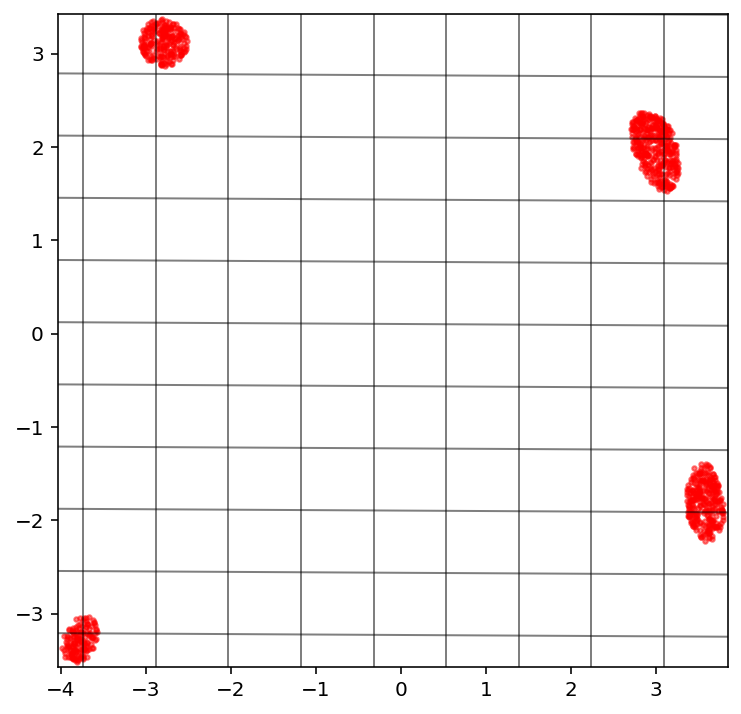

Creating directory for new run logs/test/run344
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
97.04


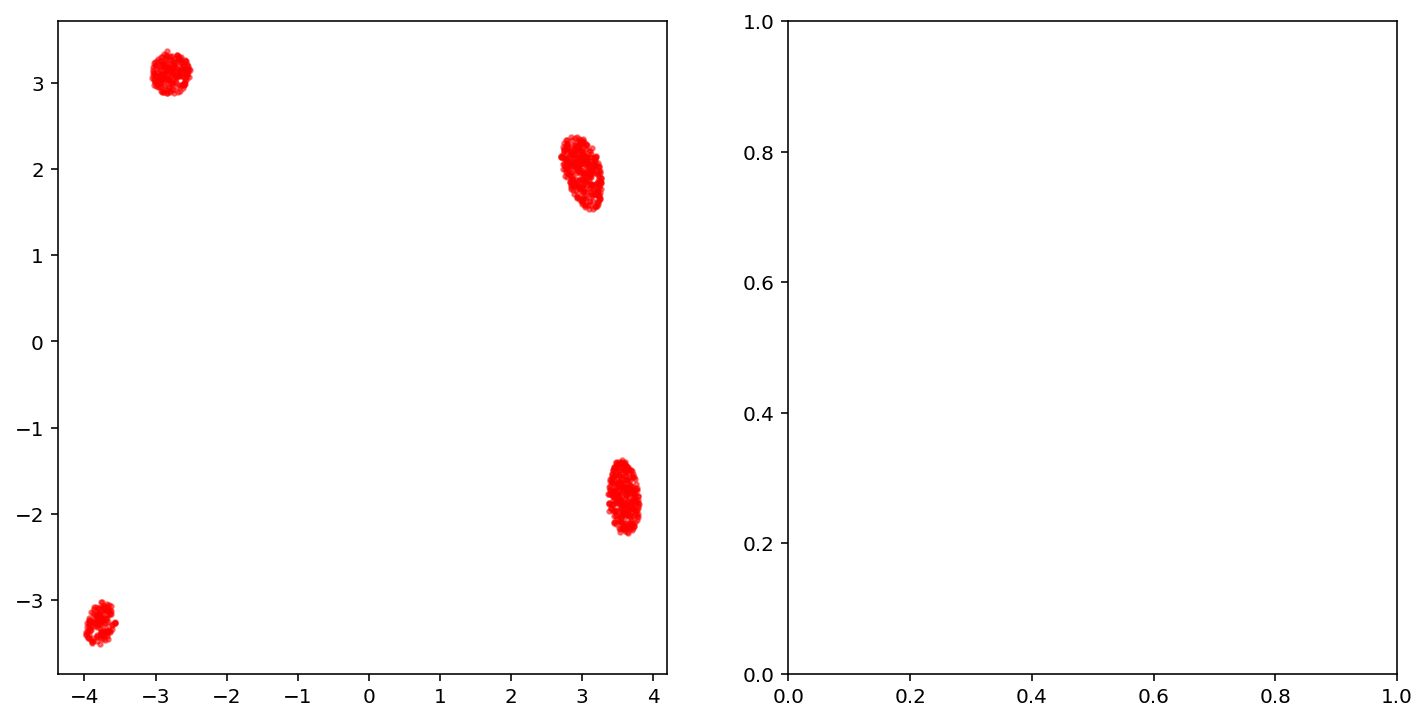

In [13]:
model = Trainer(like.x_dim, flow='choleksy', learning_rate=0.001)
test_rejection(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedNVP(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): Tanh()
          (6): Linear(in_features=64, out_features=2, bias=True)
        )
        (translate_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): ReLU()
          (6): Linear(in_features=64, out_features=2, bias=True)
        )
      )
      (1): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
     

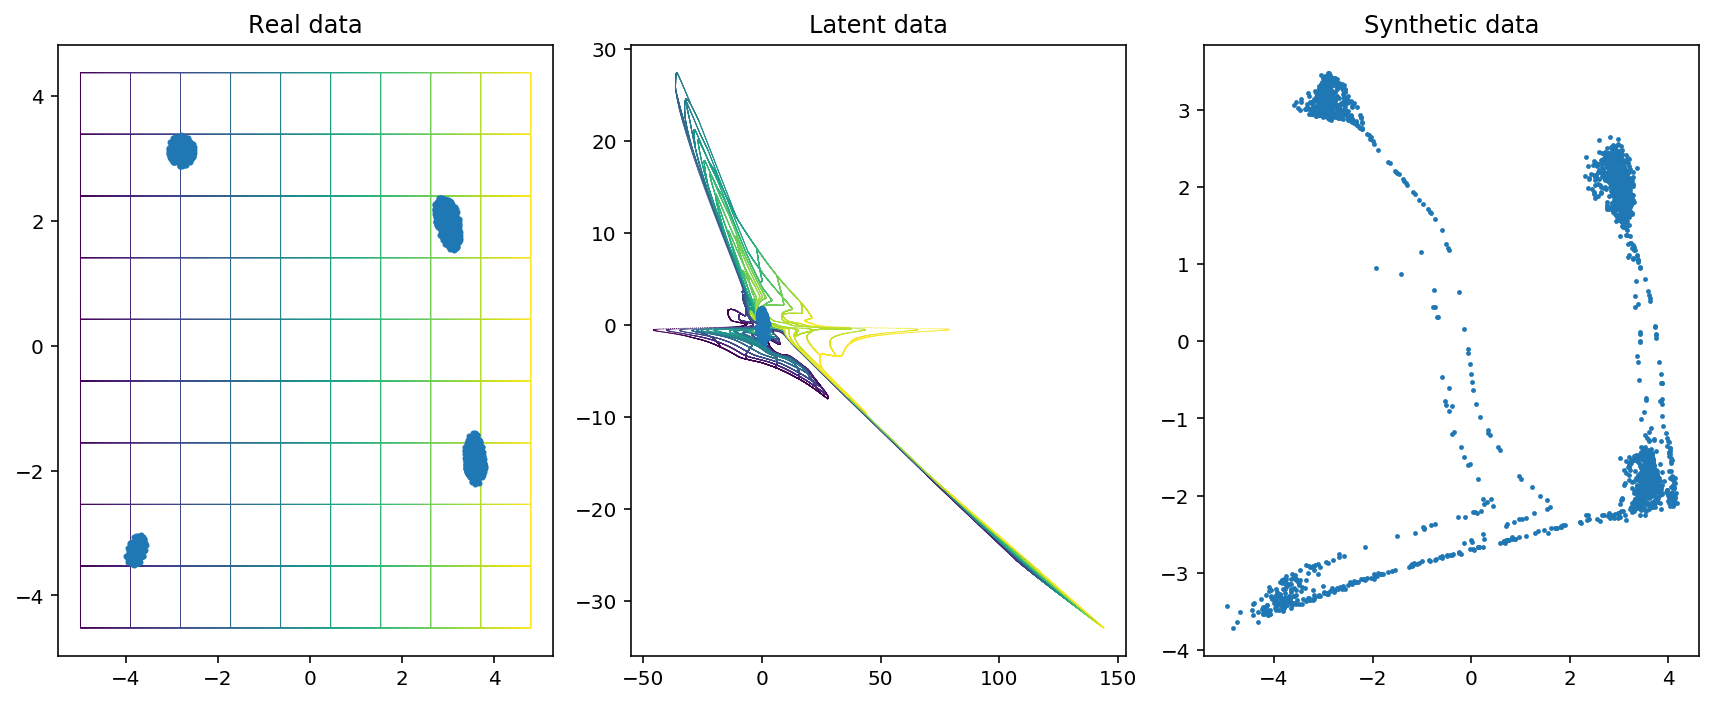

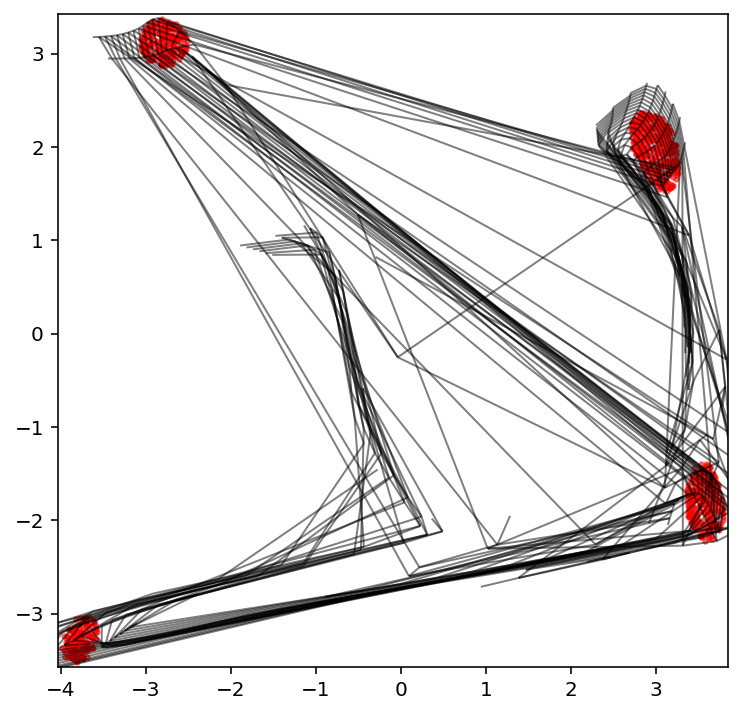

Creating directory for new run logs/test/run345
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
5.251


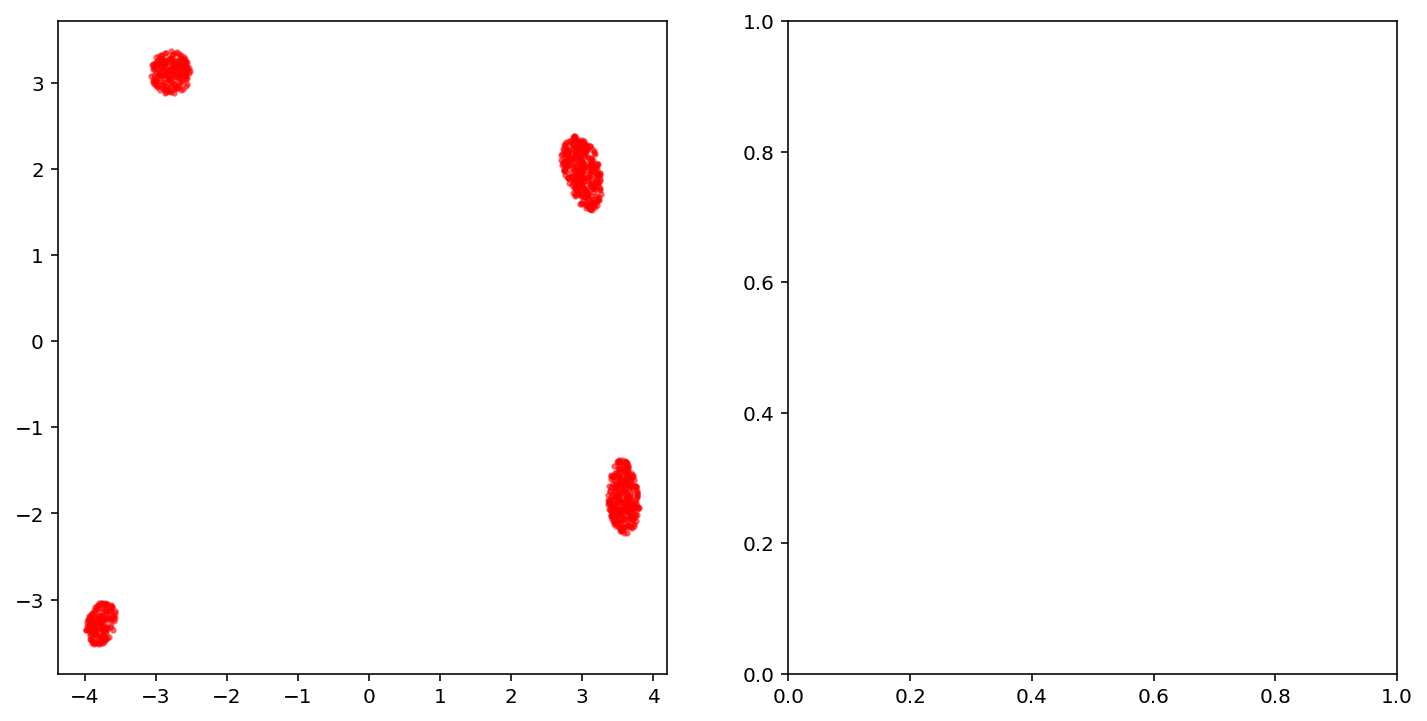

In [14]:
model = Trainer(like.x_dim, hidden_dim=64, num_blocks=5, flow='nvp', learning_rate=0.001)
test_rejection(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

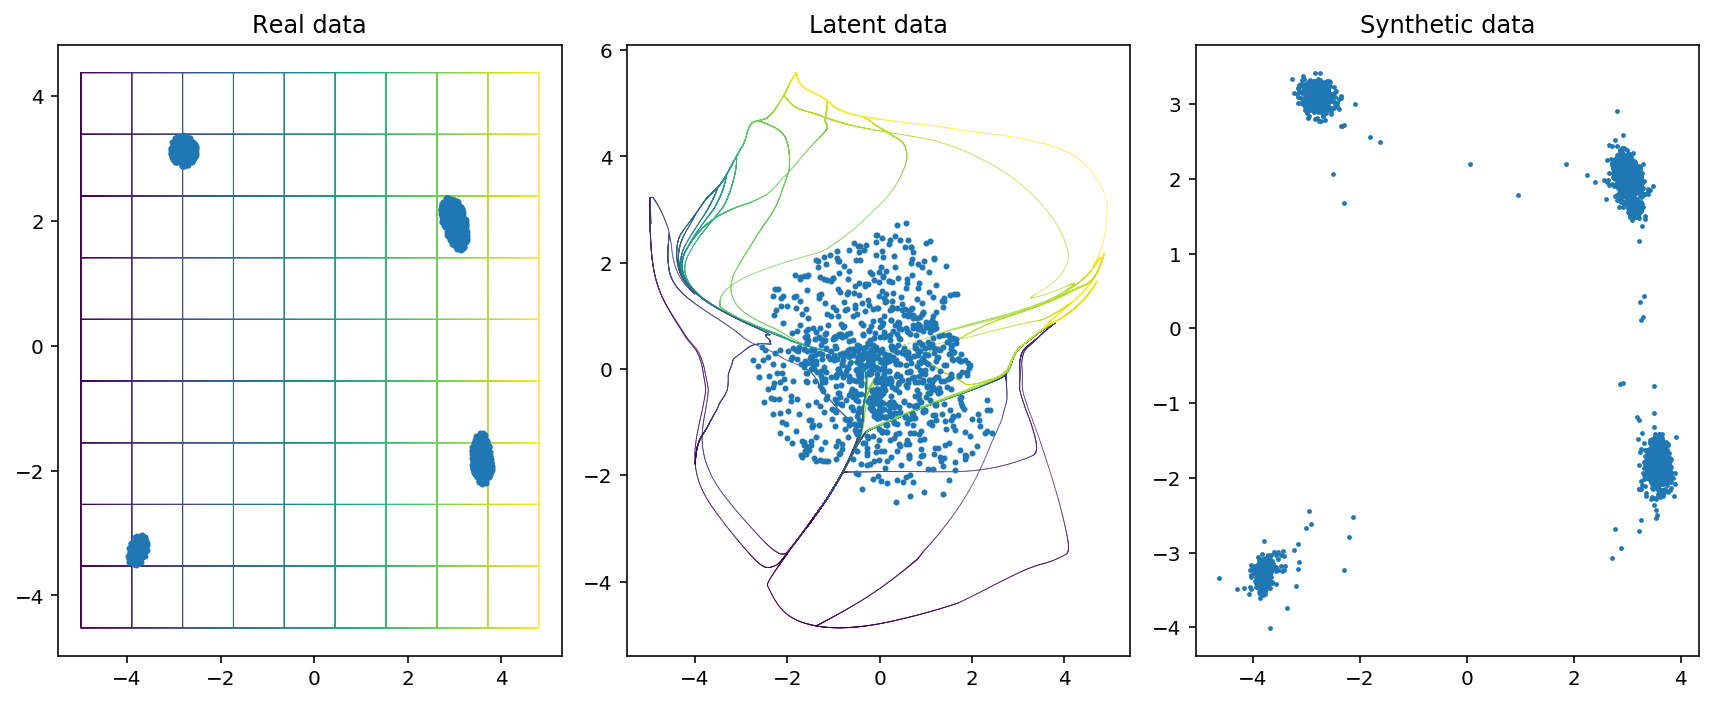

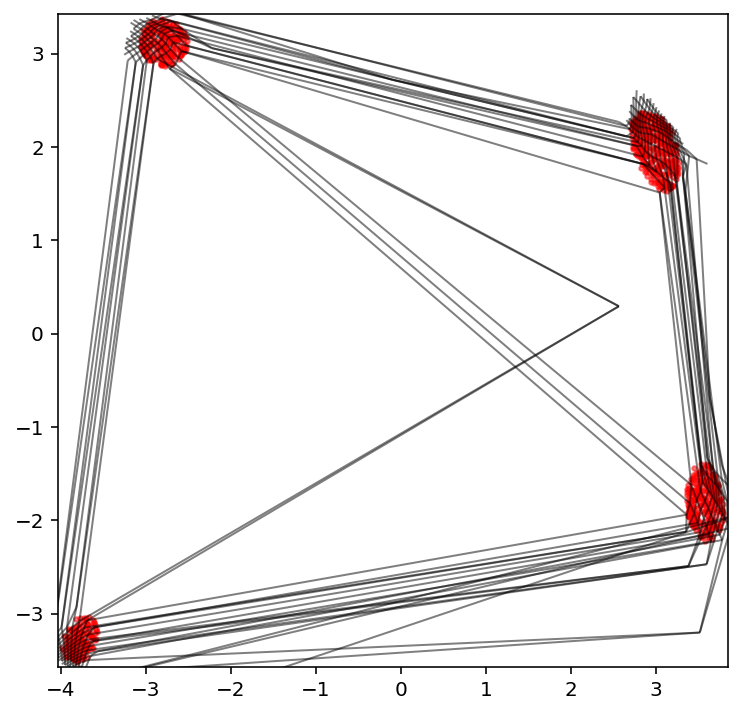

Creating directory for new run logs/test/run346
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
3.152


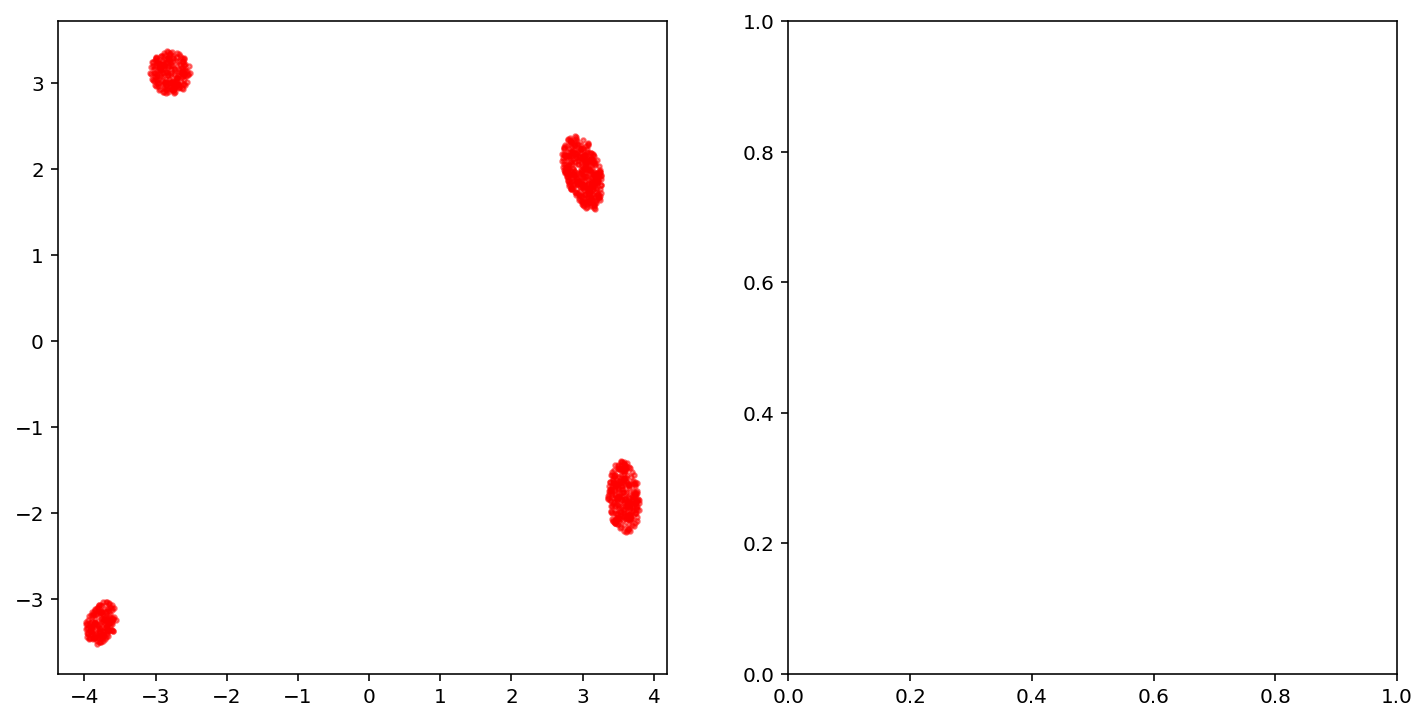

In [15]:
model = Trainer(like.x_dim, flow='spline', learning_rate=0.001)
test_rejection(like, prior, model)

In [16]:
like = Rosenbrock(2)
prior = UniformPrior(2, -2, 12)

[nnest.trainer] [INFO] SingleSpeedCholeksy(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): Choleksy()
    )
  )
)
[nnest.trainer] [INFO] Number of network params: [5]
[nnest.trainer] [INFO] Device [cpu]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0010]
[nnest.trainer] [INFO] Epoch [1] train loss [0.1009] validation loss [0.1048]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0389] validation loss [0.0387]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0351] validation loss [0.0347]
[nnest.trainer] [INFO] Epoch [300] train loss [0.0347] validation loss [0.0342]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0345] validation loss [0.0341]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0345] validation loss [0.0340]
[nnest.trainer] [INFO] Epoch [600] train loss [0.0344] validation loss [0.0339]
[nnest.trainer] [INFO] Epoch [700] train loss [0.0344] validation loss [0.0339]
[nnest.trainer] [INFO] Epoch [800] tra

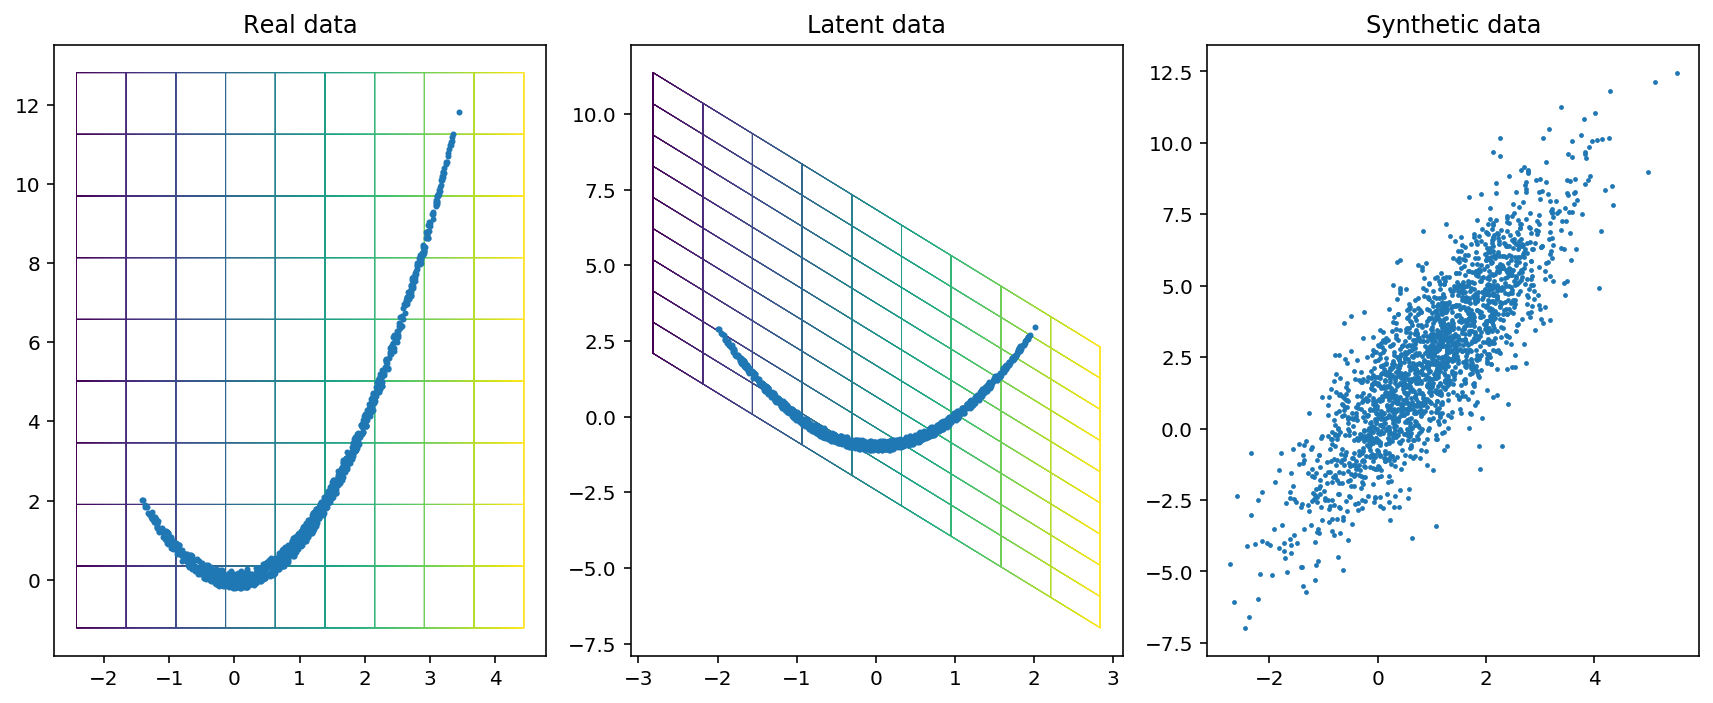

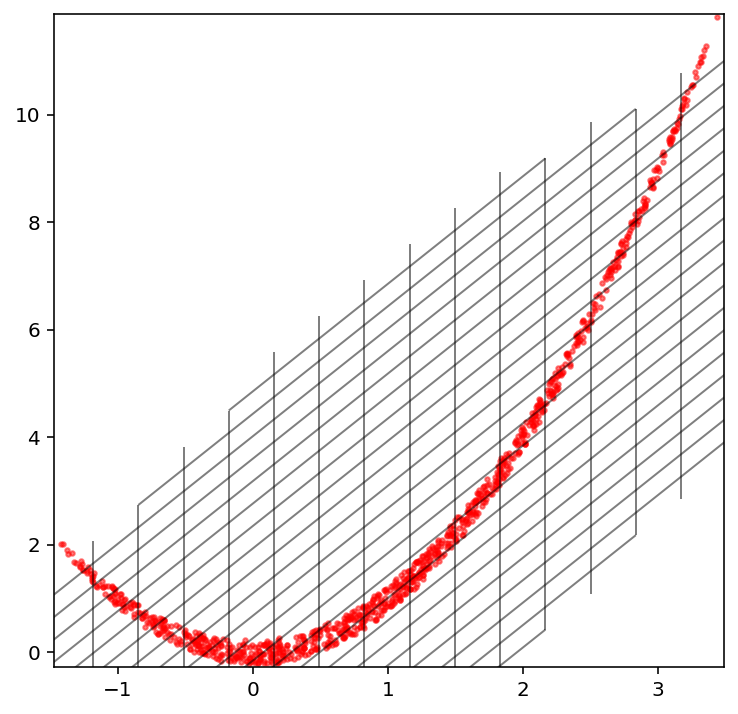

Creating directory for new run logs/test/run347
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
32.704


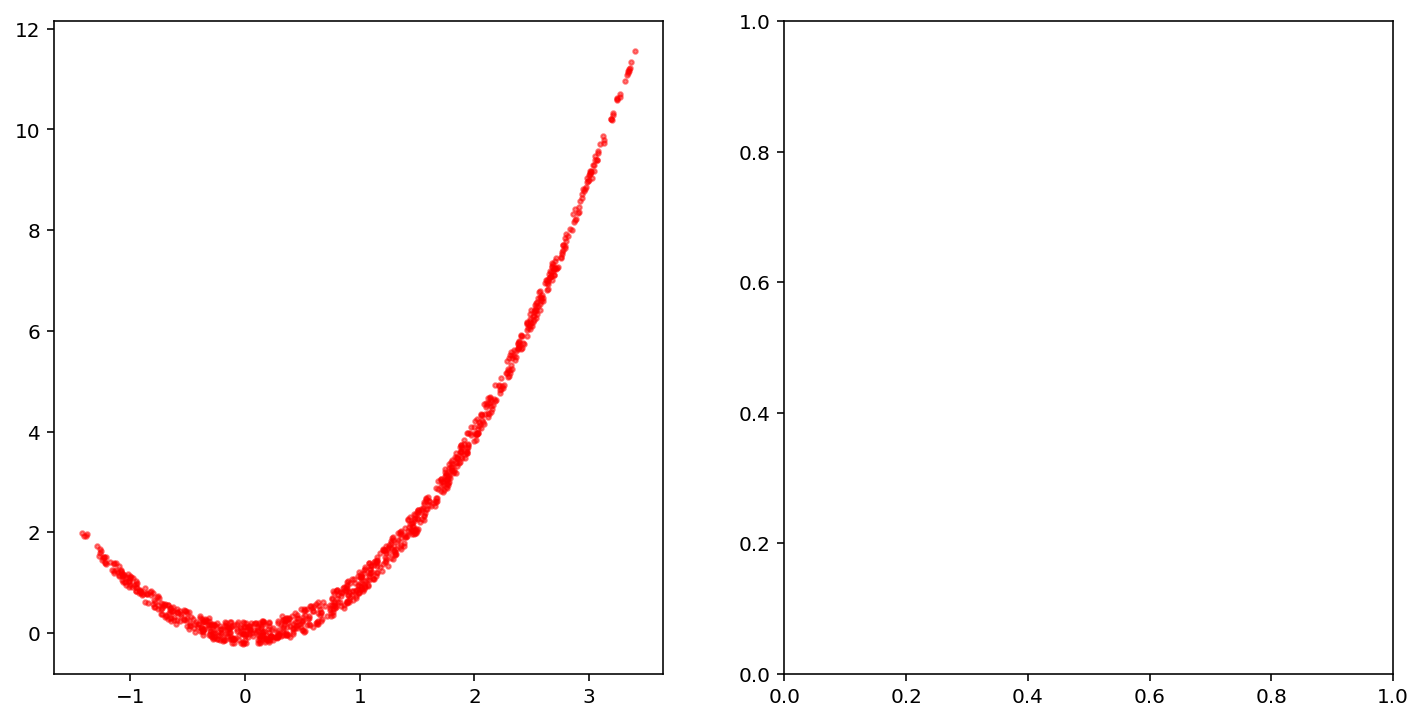

In [17]:
model = Trainer(like.x_dim, flow='choleksy', learning_rate=0.001)
test_rejection(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedNVP(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): Tanh()
          (6): Linear(in_features=64, out_features=2, bias=True)
        )
        (translate_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): ReLU()
          (6): Linear(in_features=64, out_features=2, bias=True)
        )
      )
      (1): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
     

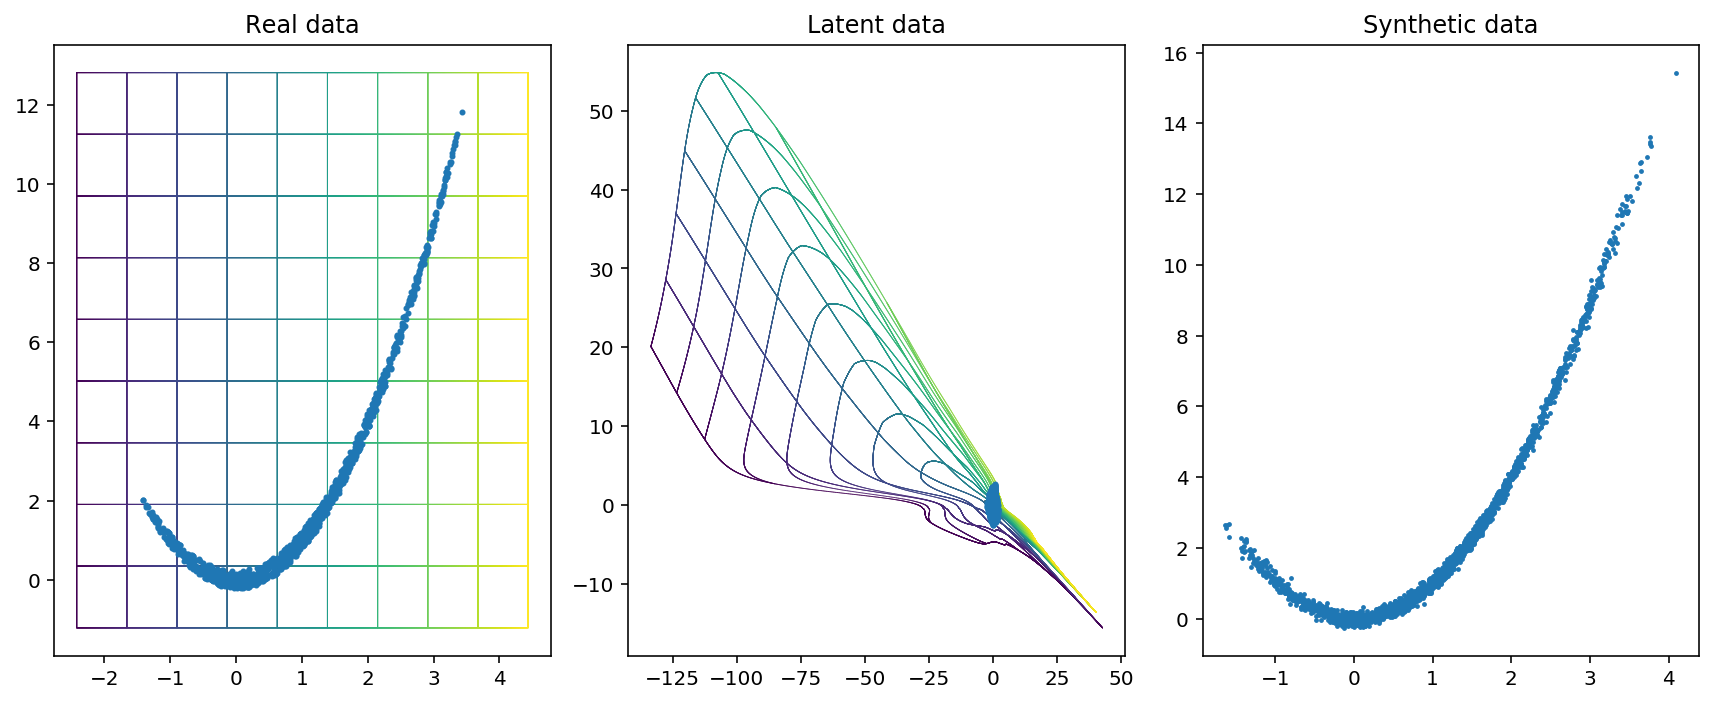

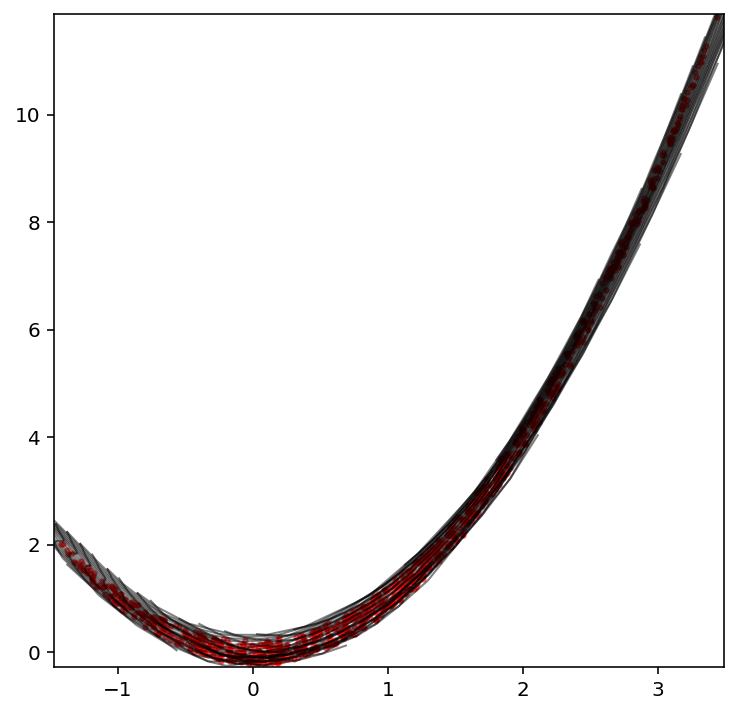

Creating directory for new run logs/test/run350
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
1.874


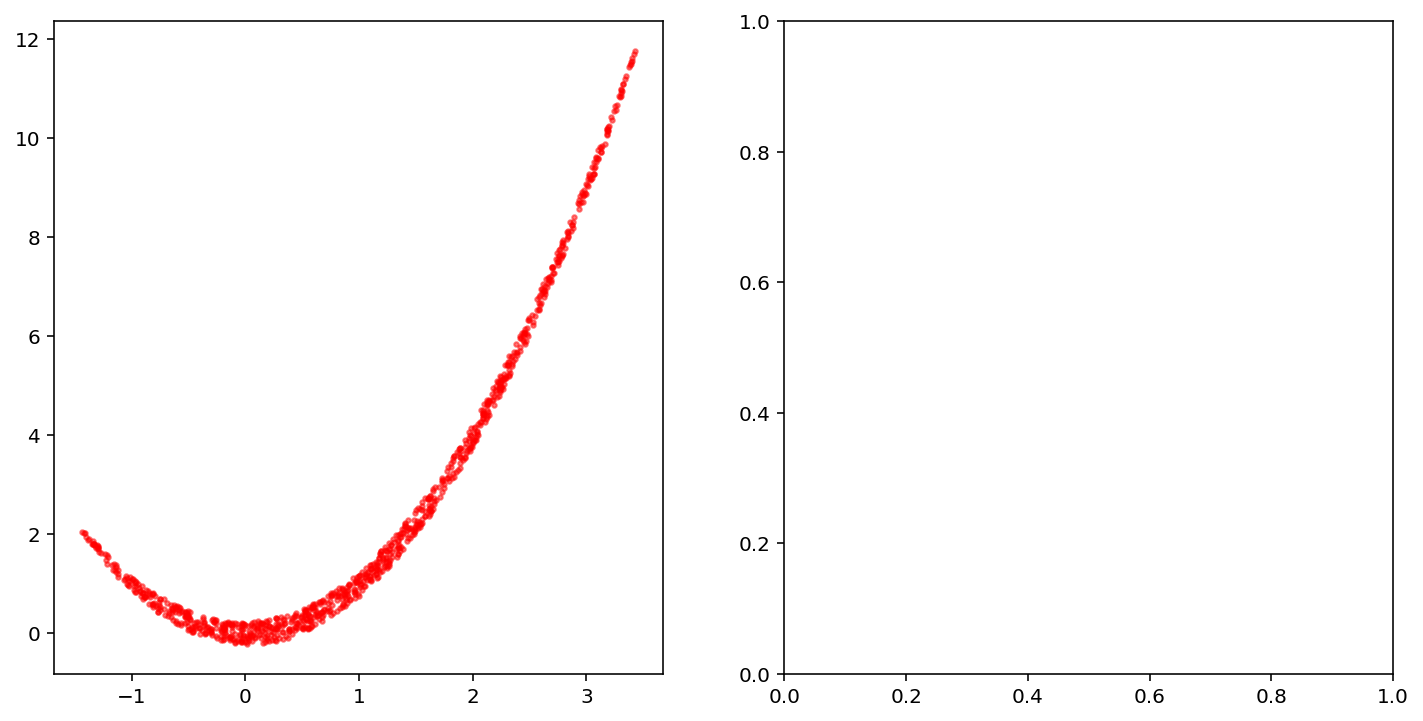

In [18]:
model = Trainer(like.x_dim, hidden_dim=64, num_blocks=5, flow='nvp', learning_rate=0.001)
test_rejection(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

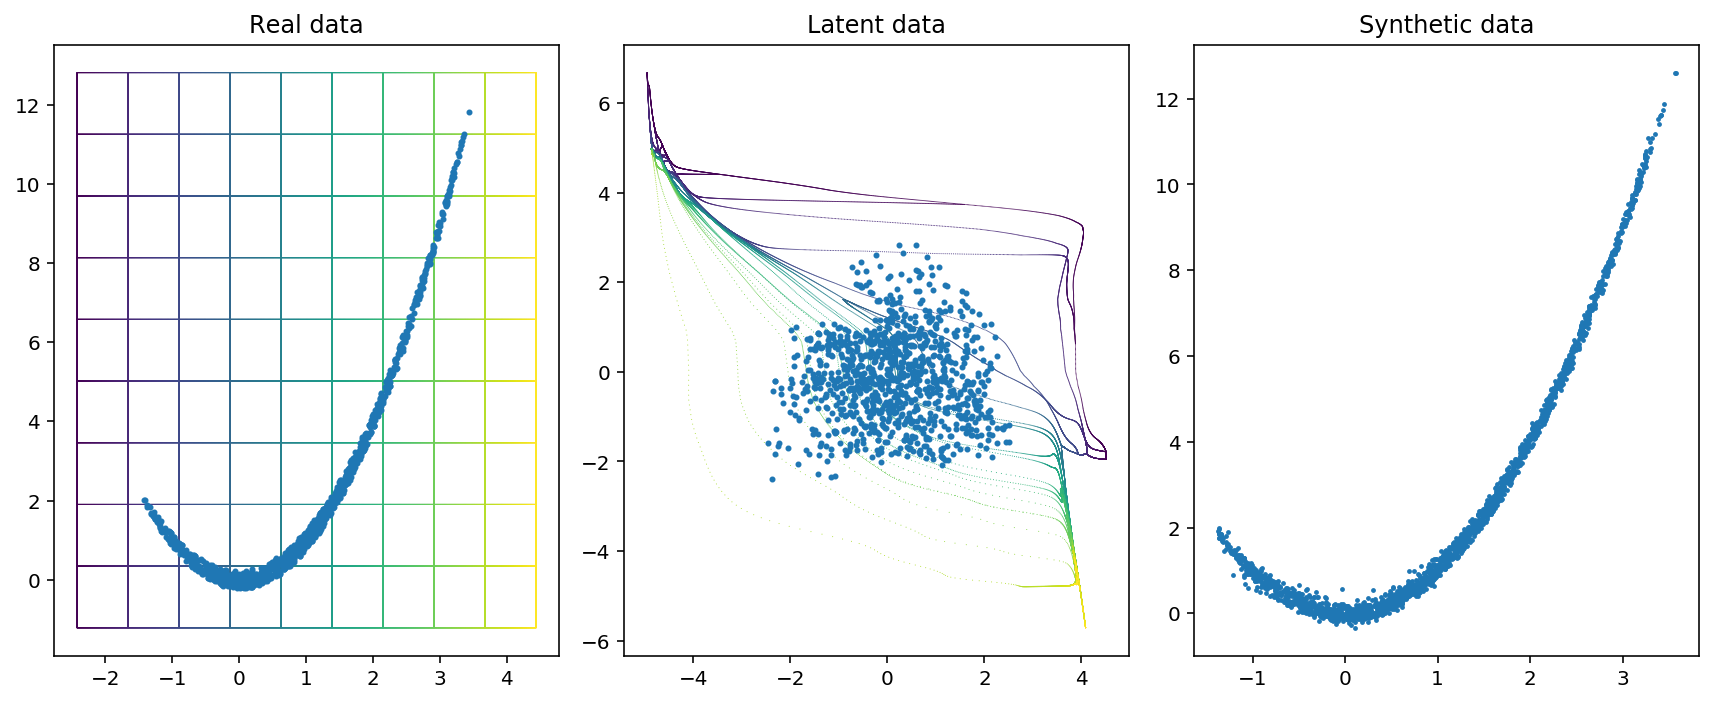

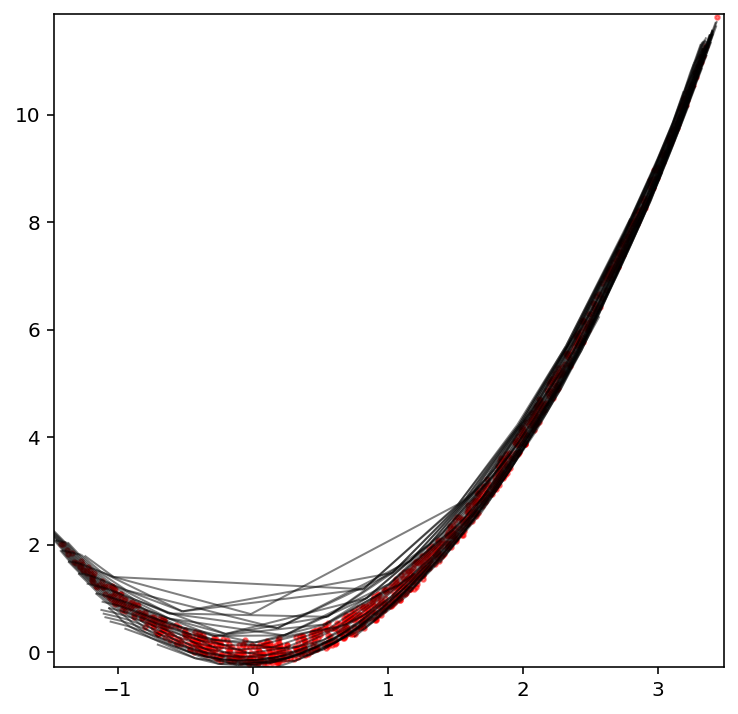

Creating directory for new run logs/test/run353
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
2.331


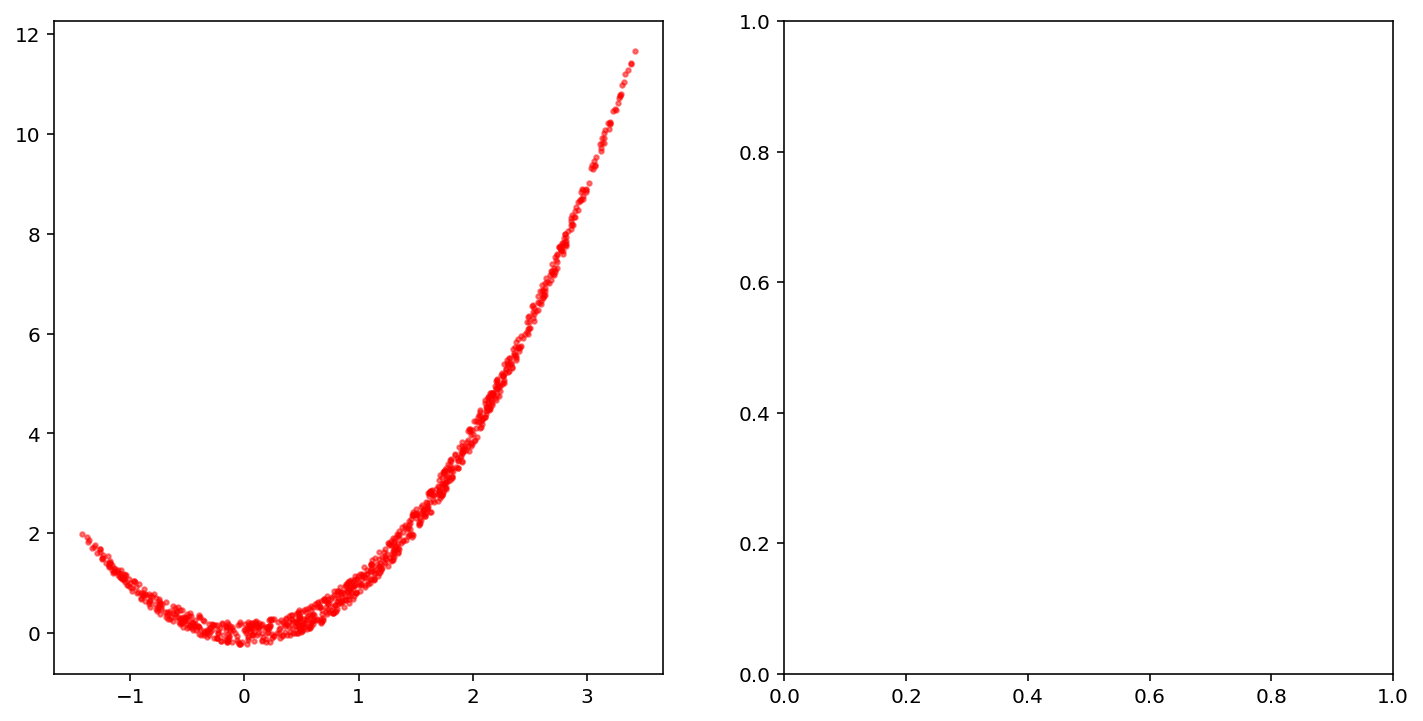

In [19]:
model = Trainer(like.x_dim, flow='spline', learning_rate=0.001)
test_rejection(like, prior, model)

In [20]:
prior = UniformPrior(2, -15, 15)
like = Eggbox(2)

[nnest.trainer] [INFO] SingleSpeedCholeksy(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): Choleksy()
    )
  )
)
[nnest.trainer] [INFO] Number of network params: [5]
[nnest.trainer] [INFO] Device [cpu]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0010]
[nnest.trainer] [INFO] Epoch [1] train loss [0.8336] validation loss [0.8679]
[nnest.trainer] [INFO] Epoch [100] train loss [0.3267] validation loss [0.3401]
[nnest.trainer] [INFO] Epoch [200] train loss [0.1713] validation loss [0.1775]
[nnest.trainer] [INFO] Epoch [300] train loss [0.1140] validation loss [0.1173]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0899] validation loss [0.0919]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0793] validation loss [0.0806]
[nnest.trainer] [INFO] Epoch [600] train loss [0.0748] validation loss [0.0757]
[nnest.trainer] [INFO] Epoch [700] train loss [0.0730] validation loss [0.0737]
[nnest.trainer] [INFO] Epoch [800] tra

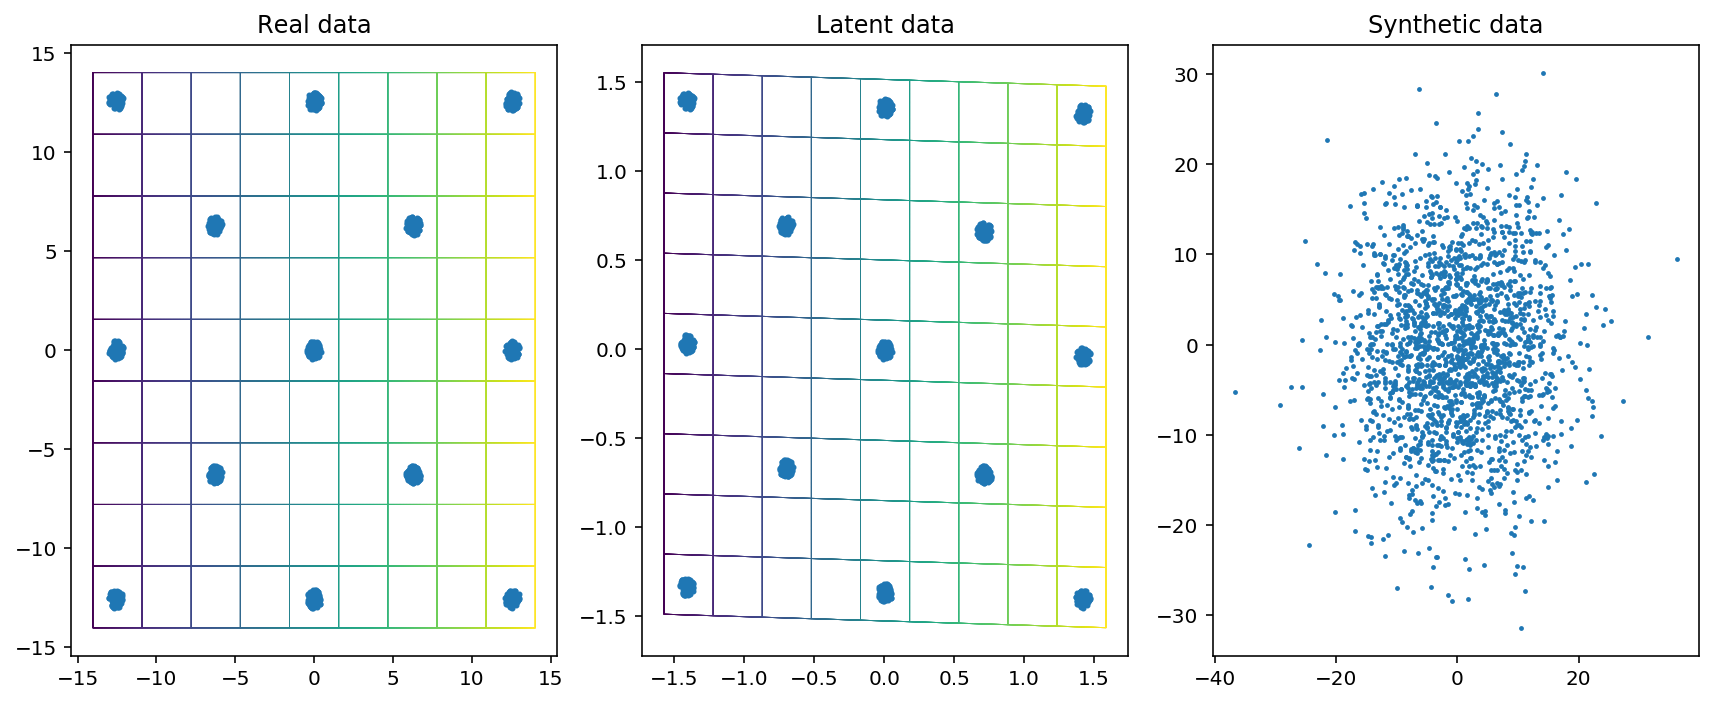

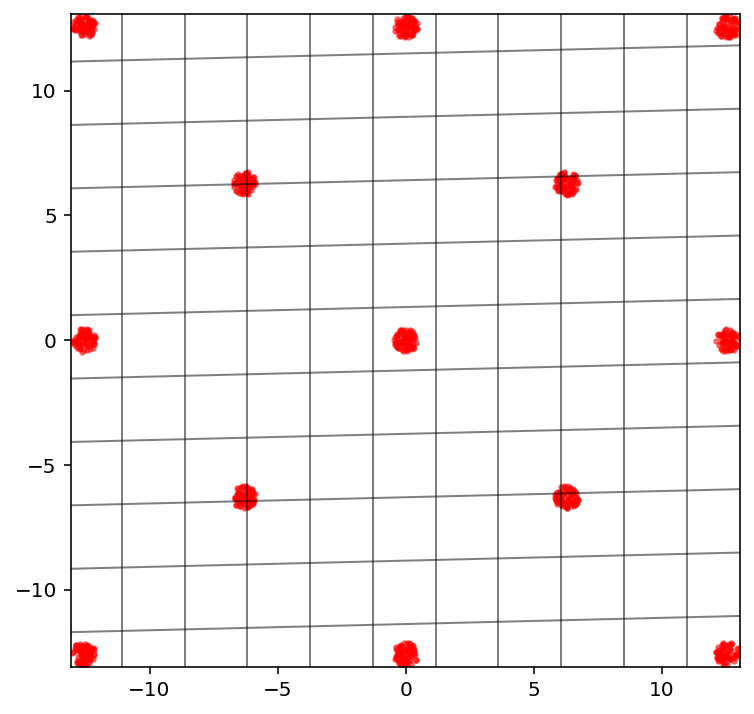

Creating directory for new run logs/test/run358
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
100.641


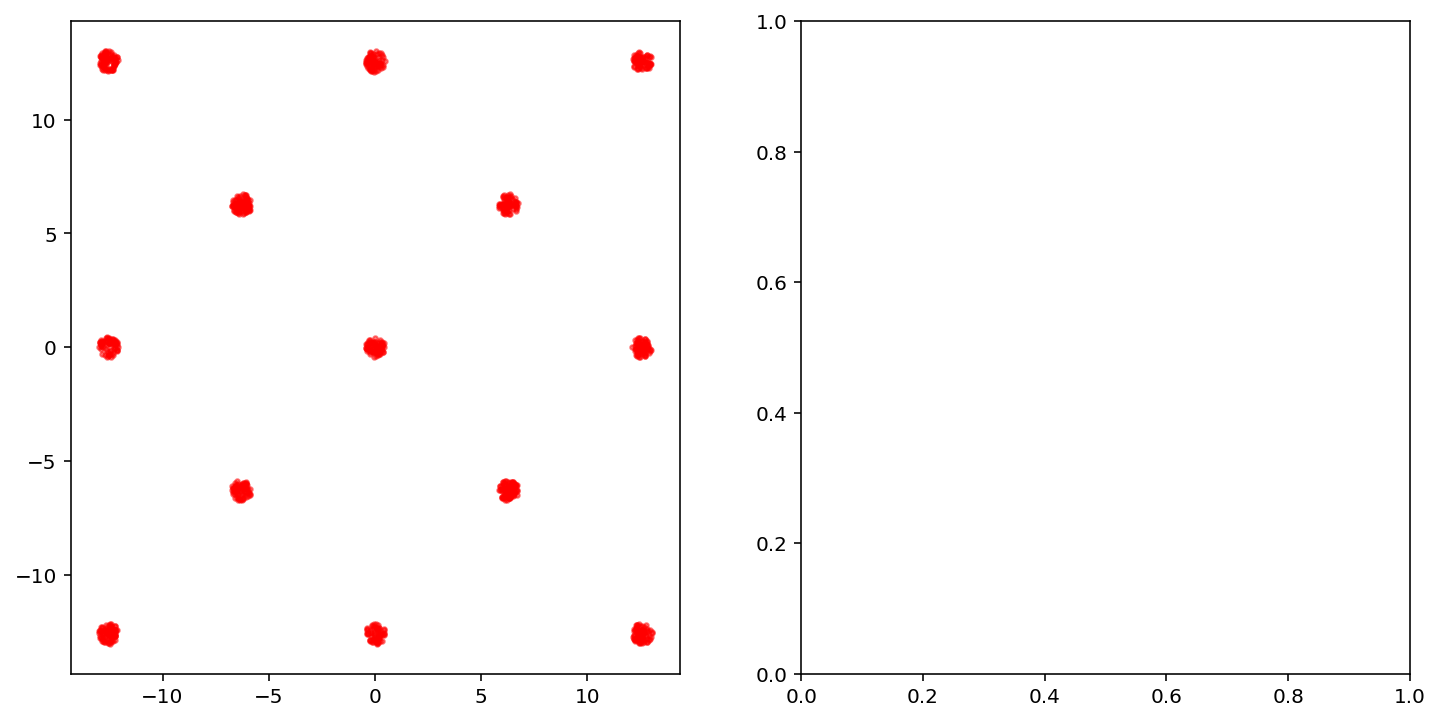

In [21]:
model = Trainer(like.x_dim, flow='choleksy', learning_rate=0.001)
test_rejection(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedNVP(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): Tanh()
          (6): Linear(in_features=64, out_features=2, bias=True)
        )
        (translate_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): ReLU()
          (6): Linear(in_features=64, out_features=2, bias=True)
        )
      )
      (1): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
     

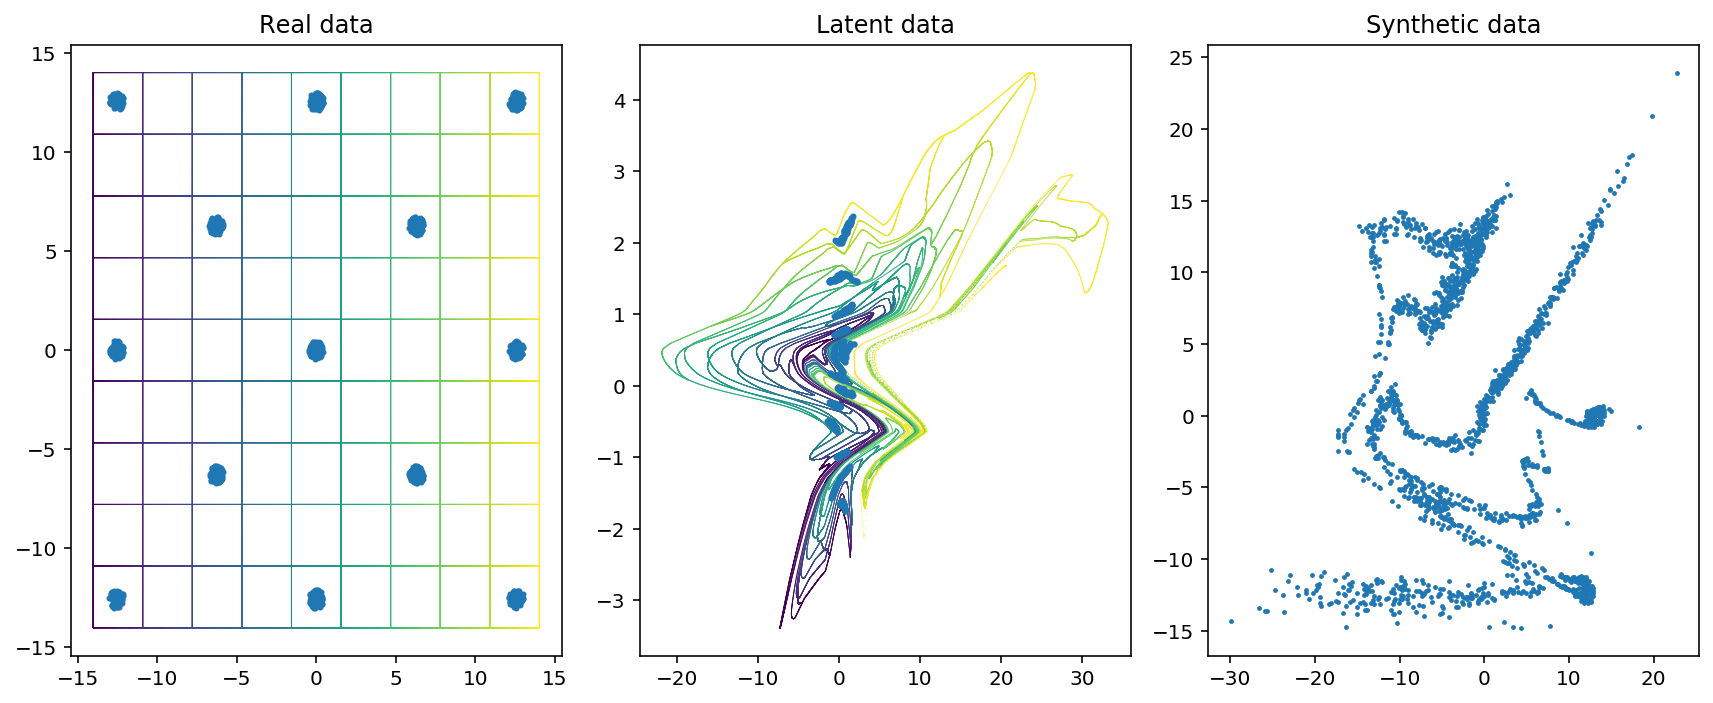

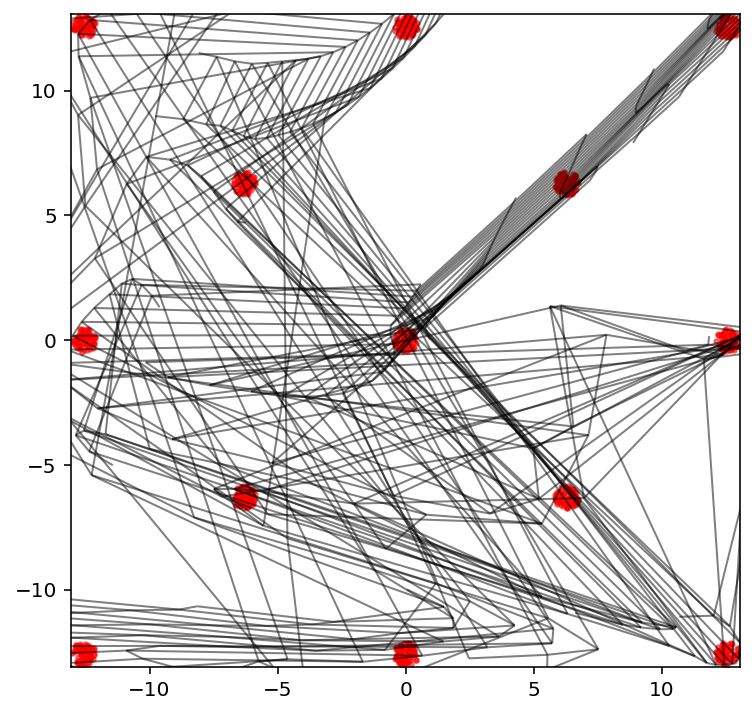

Creating directory for new run logs/test/run361
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
39.011


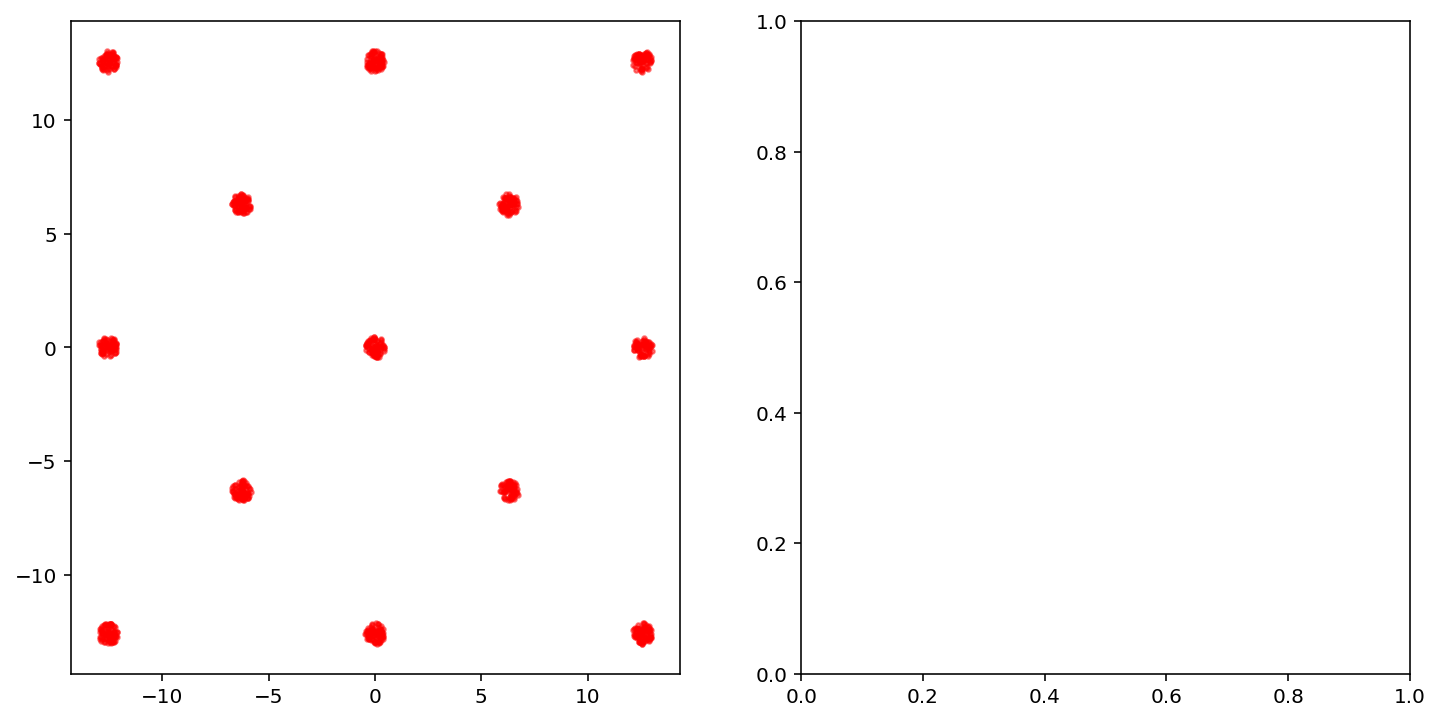

In [22]:
model = Trainer(like.x_dim, hidden_dim=64, num_blocks=5, flow='nvp', learning_rate=0.001)
test_rejection(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

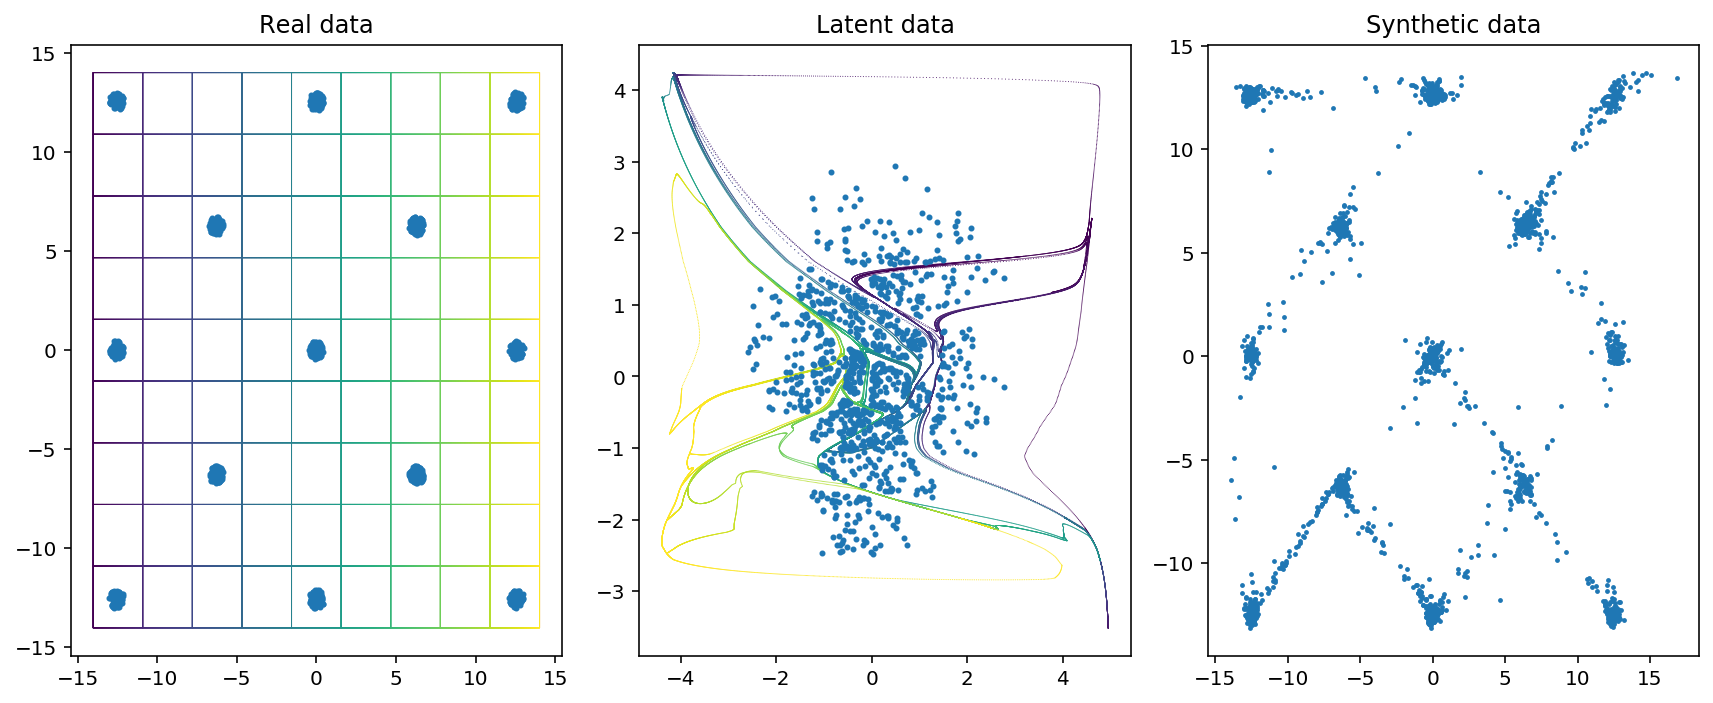

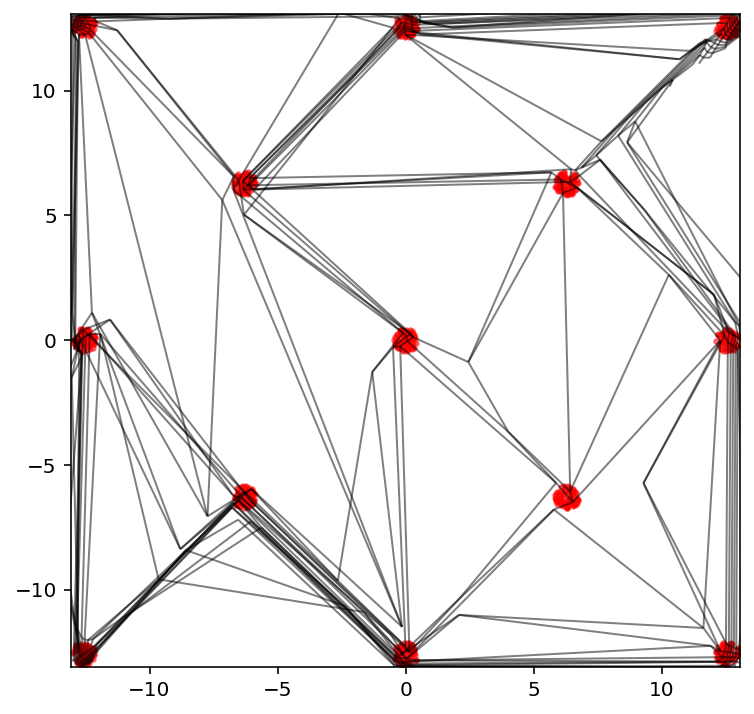

Creating directory for new run logs/test/run372
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
11.88


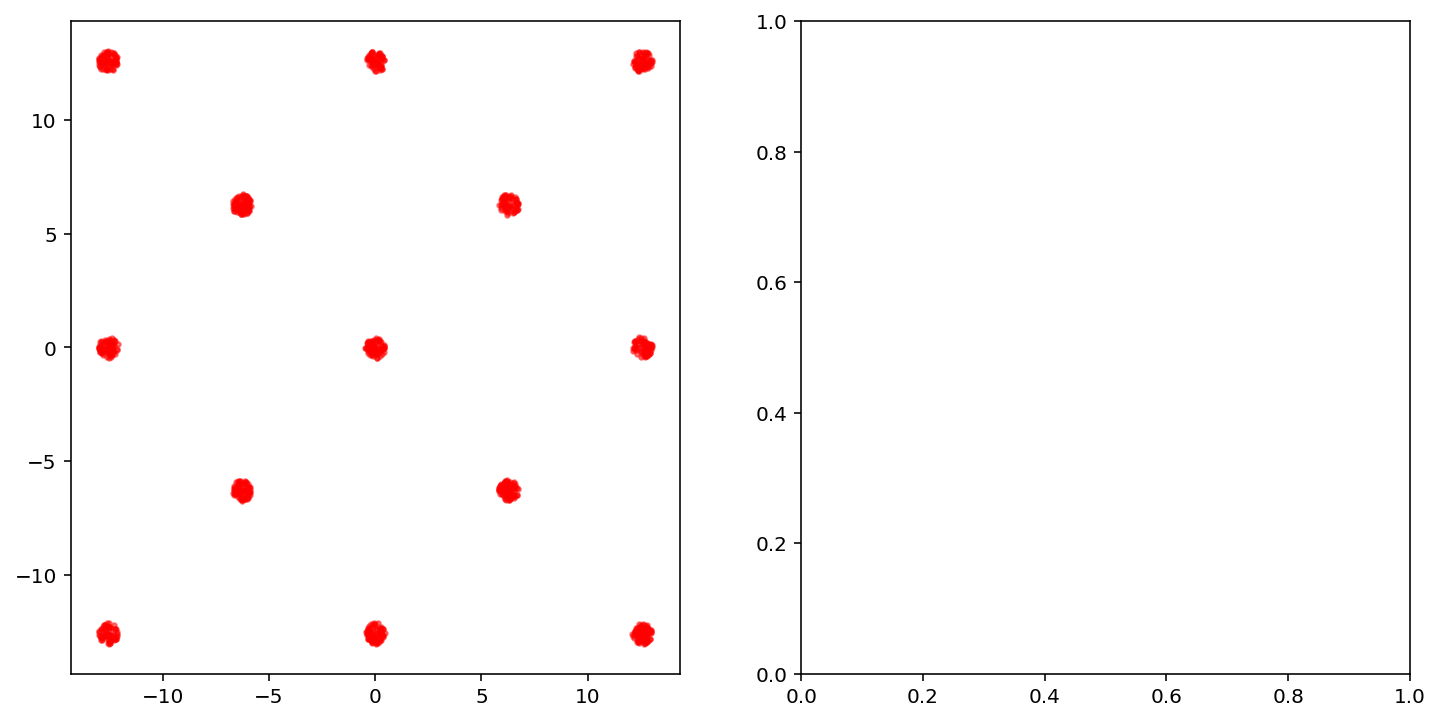

In [23]:
model = Trainer(like.x_dim, flow='spline', learning_rate=0.001)
test_rejection(like, prior, model)

In [24]:
prior = UniformPrior(2, [-7, -3], [7, 3])
like = DoubleGaussianShell(2, centers=[[-4.0, 0.0], [4.0, 0.0]])

[nnest.trainer] [INFO] SingleSpeedCholeksy(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): Choleksy()
    )
  )
)
[nnest.trainer] [INFO] Number of network params: [5]
[nnest.trainer] [INFO] Device [cpu]
[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0010]
[nnest.trainer] [INFO] Epoch [1] train loss [0.1206] validation loss [0.1180]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0661] validation loss [0.0657]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0519] validation loss [0.0519]
[nnest.trainer] [INFO] Epoch [300] train loss [0.0478] validation loss [0.0479]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0467] validation loss [0.0468]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0465] validation loss [0.0466]
[nnest.trainer] [INFO] Epoch [600] train loss [0.0464] validation loss [0.0466]
[nnest.trainer] [INFO] Epoch [699] ran out of patience
[nnest.trainer] [INFO] Best epoch [649] validation loss [0.0466

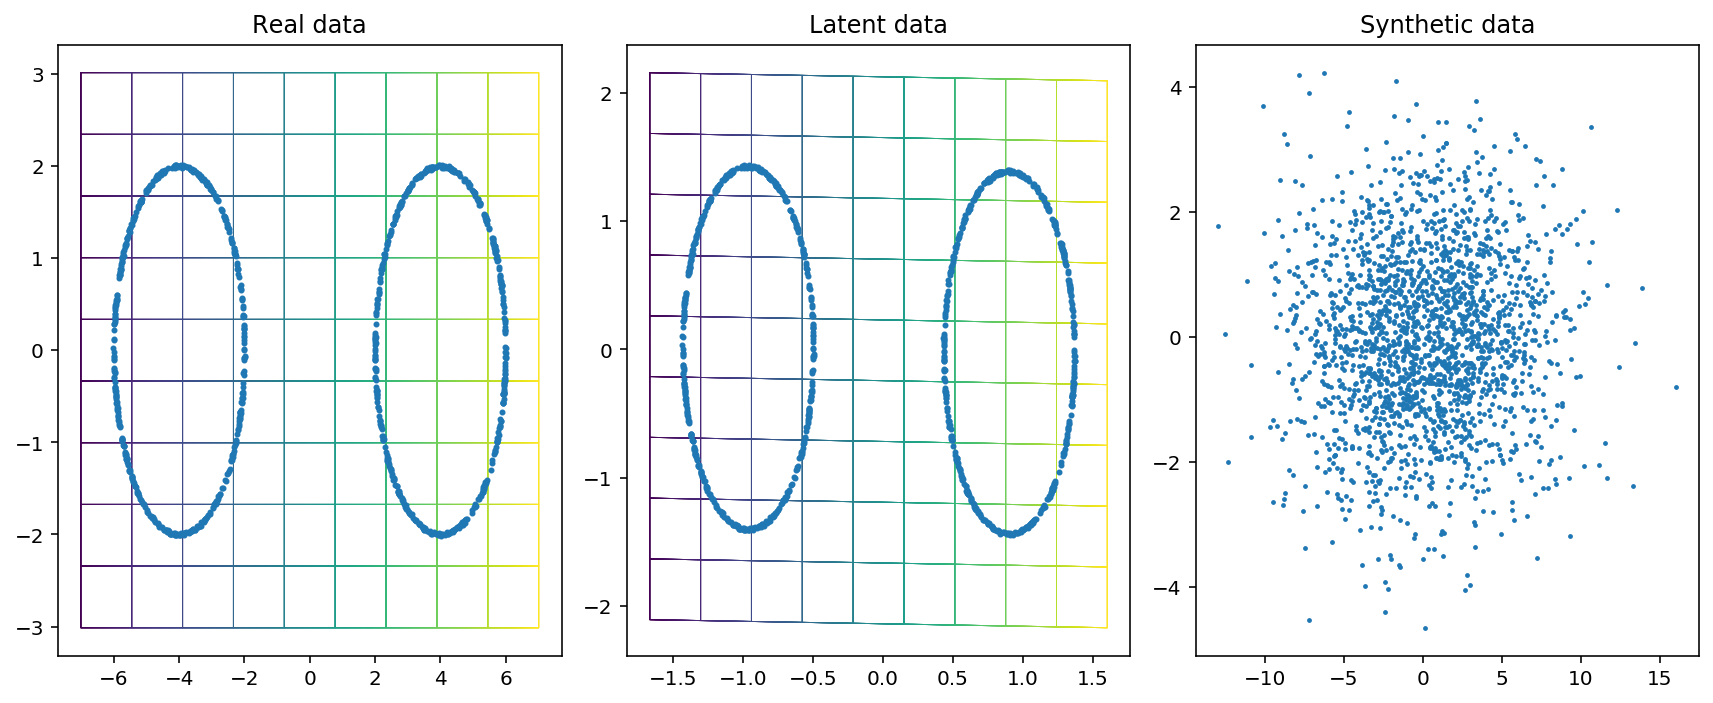

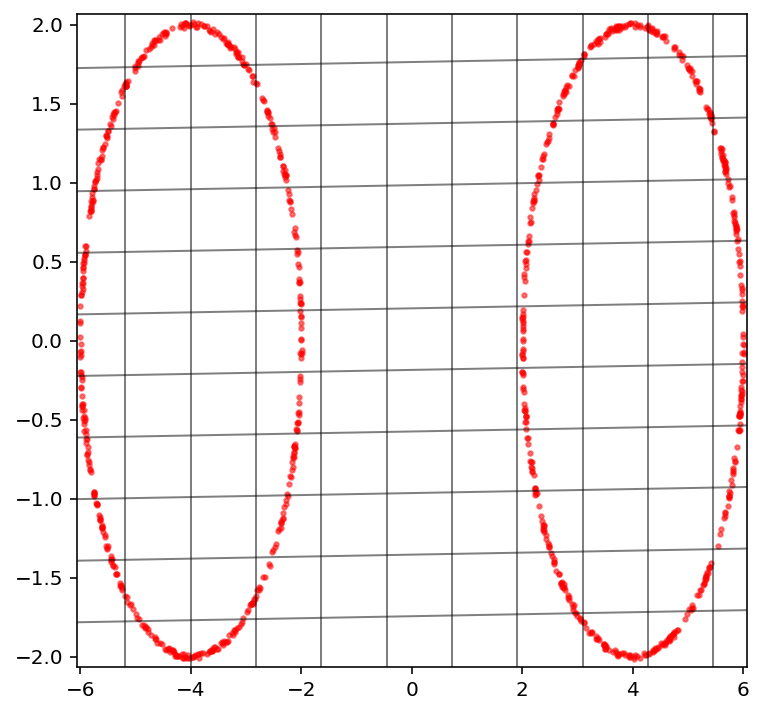

Creating directory for new run logs/test/run401
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
82.251


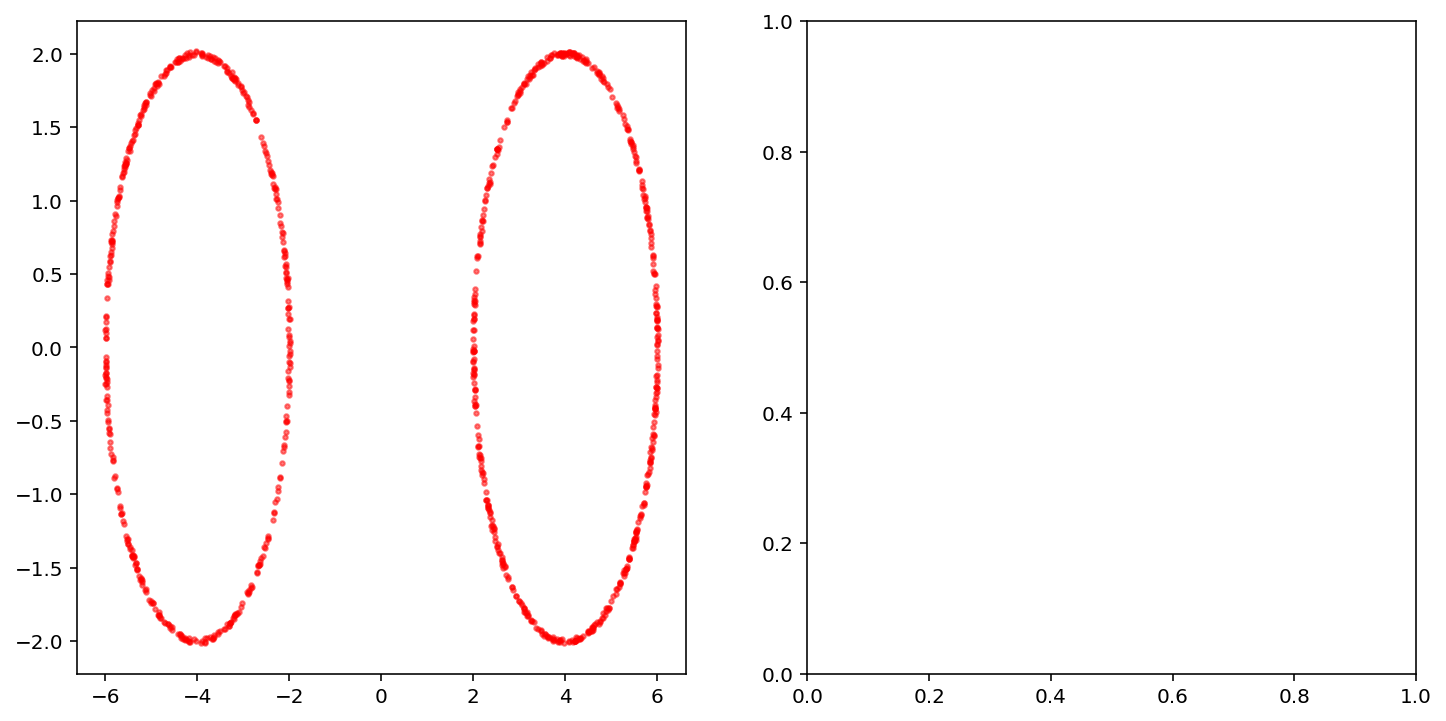

In [25]:
model = Trainer(like.x_dim, flow='choleksy', learning_rate=0.001)
test_rejection(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedNVP(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): Tanh()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): Tanh()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): Tanh()
          (6): Linear(in_features=64, out_features=2, bias=True)
        )
        (translate_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): Linear(in_features=64, out_features=64, bias=True)
          (5): ReLU()
          (6): Linear(in_features=64, out_features=2, bias=True)
        )
      )
      (1): CouplingLayer(
        (scale_net): Sequential(
          (0): Linear(in_features=2, out_features=64, bias=True)
     

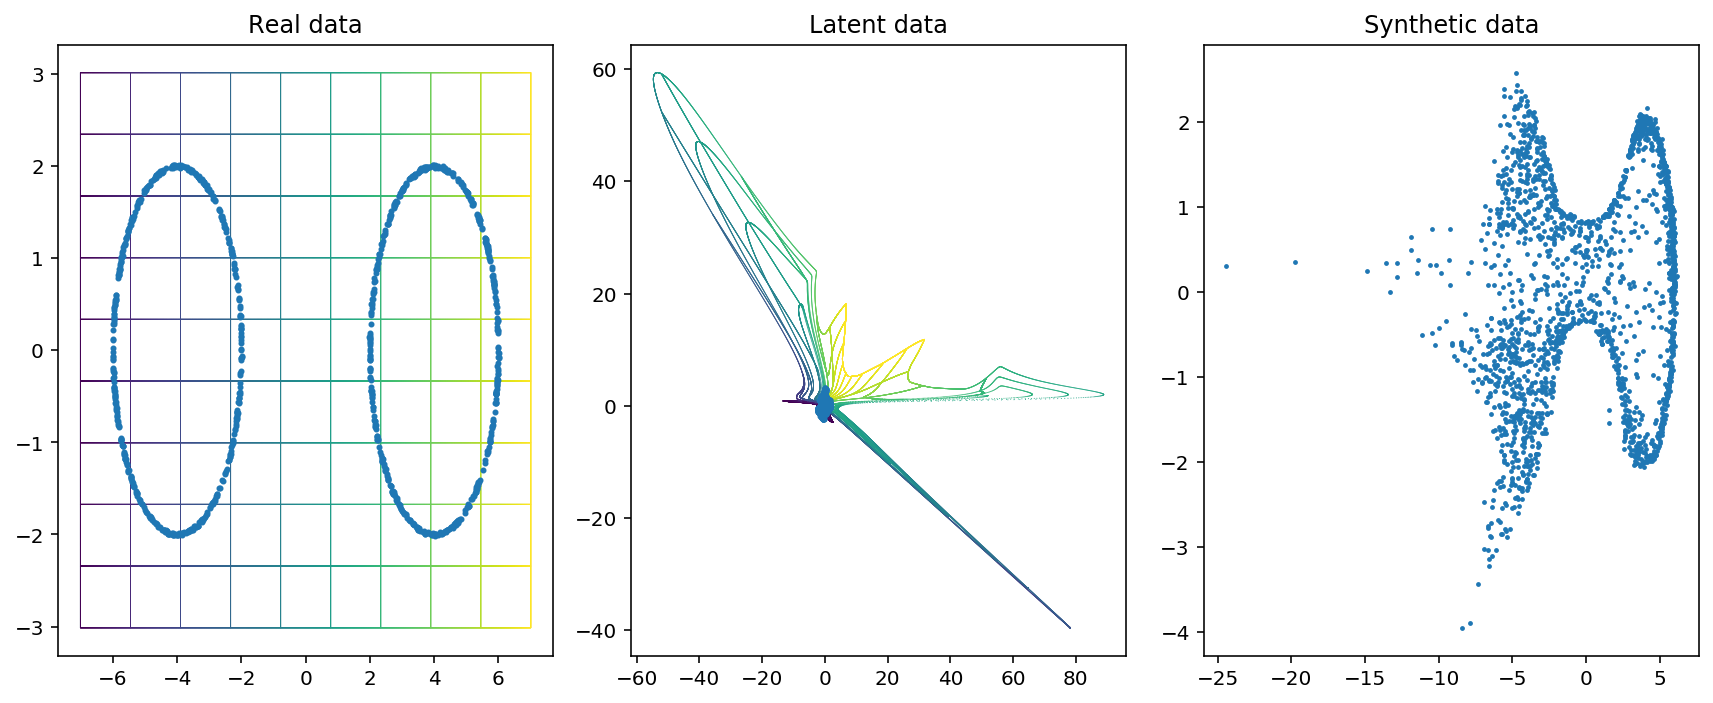

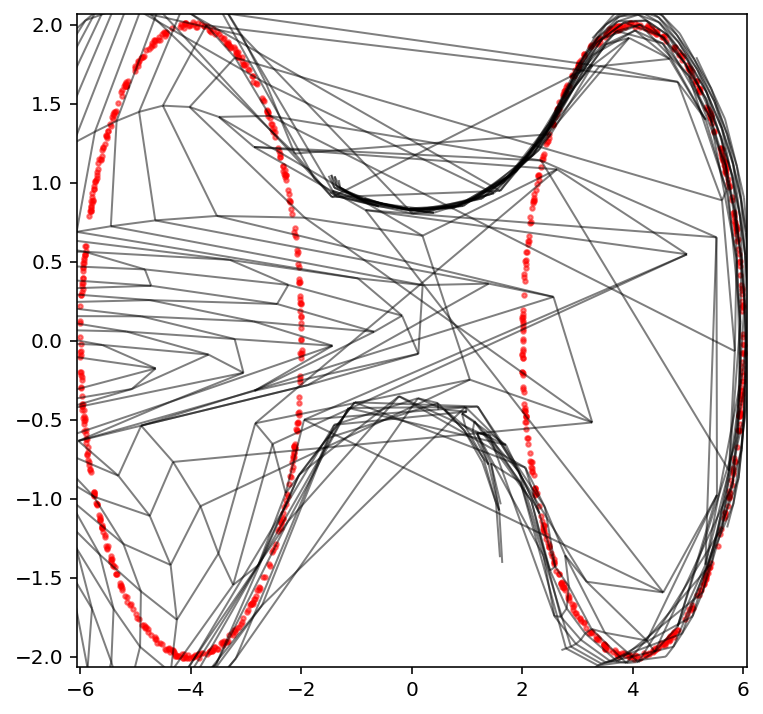

Creating directory for new run logs/test/run404
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
50.791


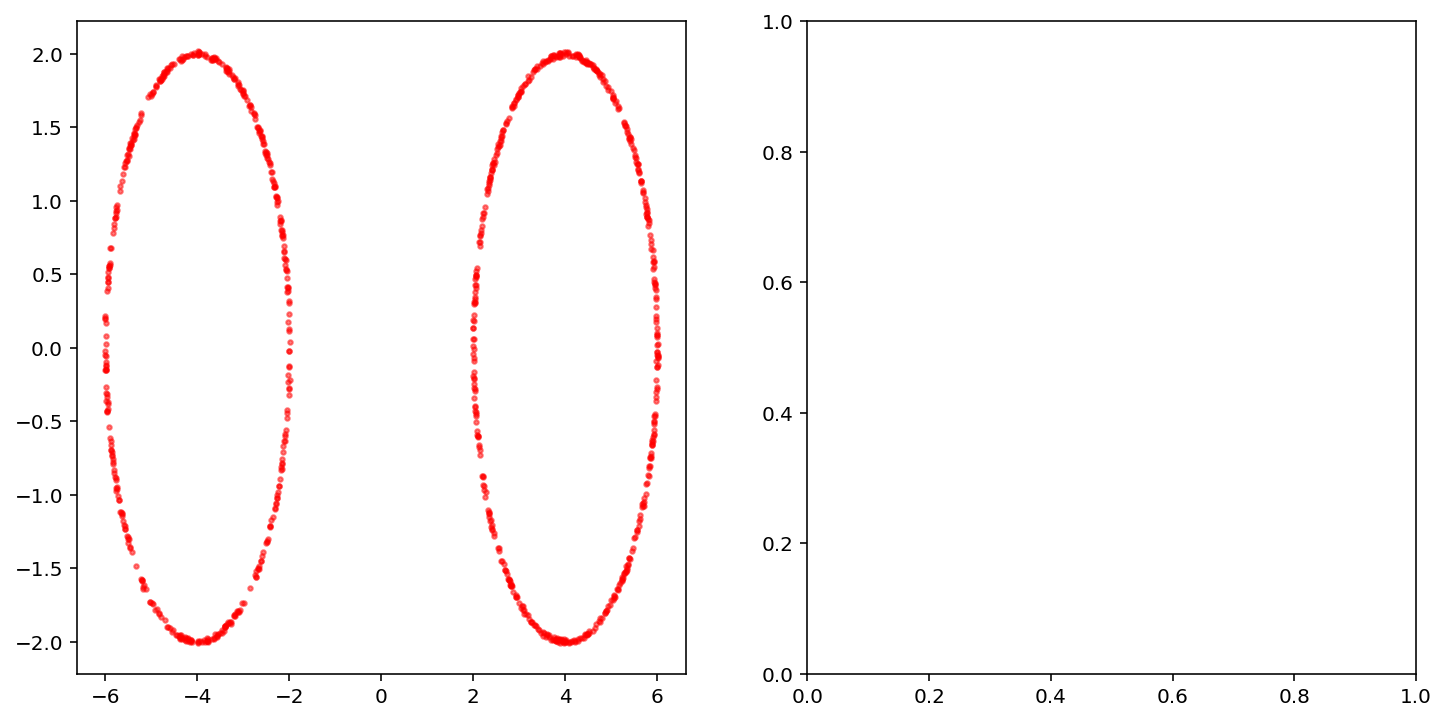

In [26]:
model = Trainer(like.x_dim, hidden_dim=64, num_blocks=5, flow='nvp', learning_rate=0.001)
test_rejection(like, prior, model)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

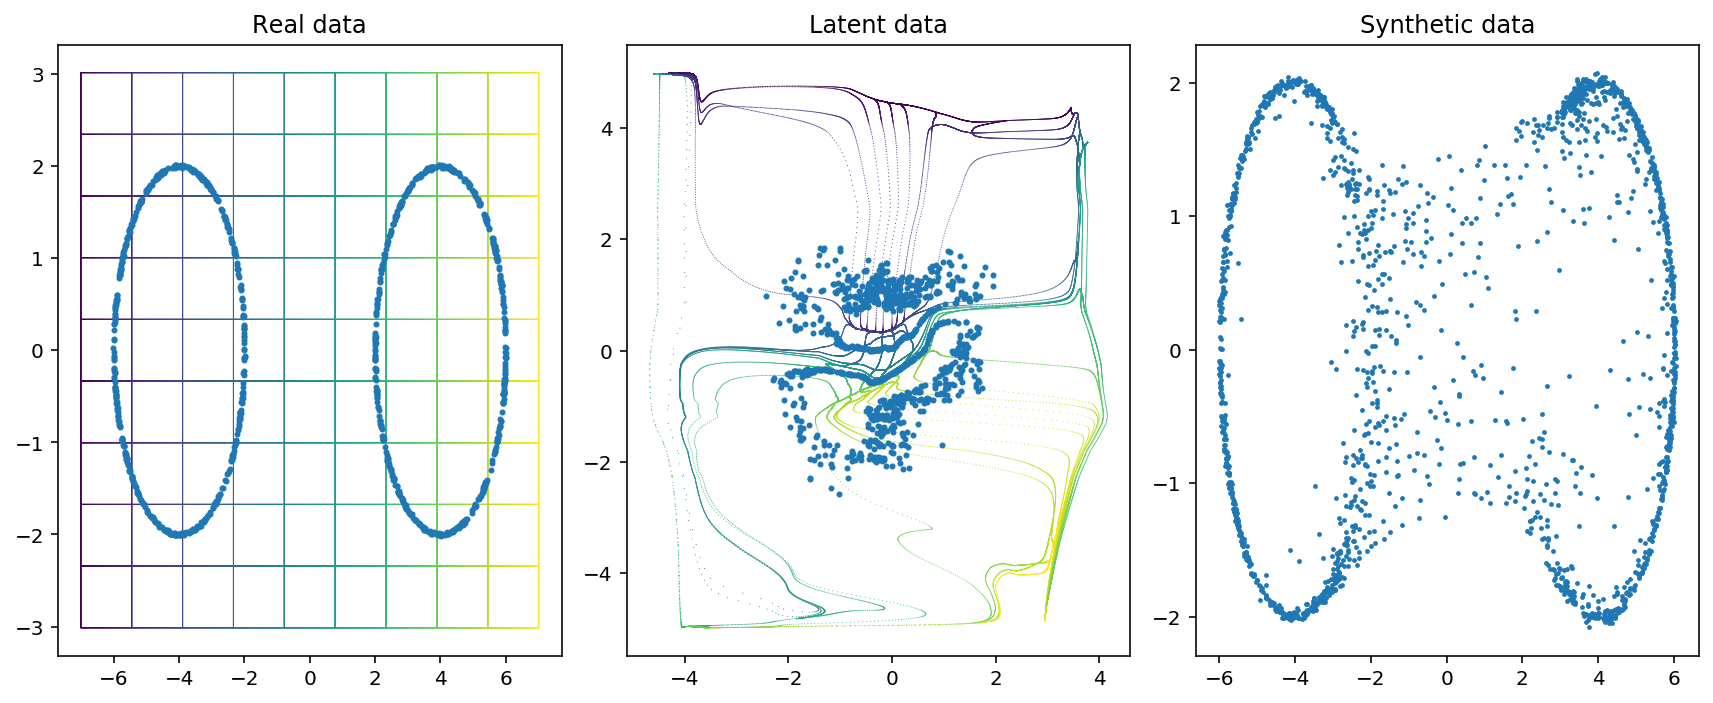

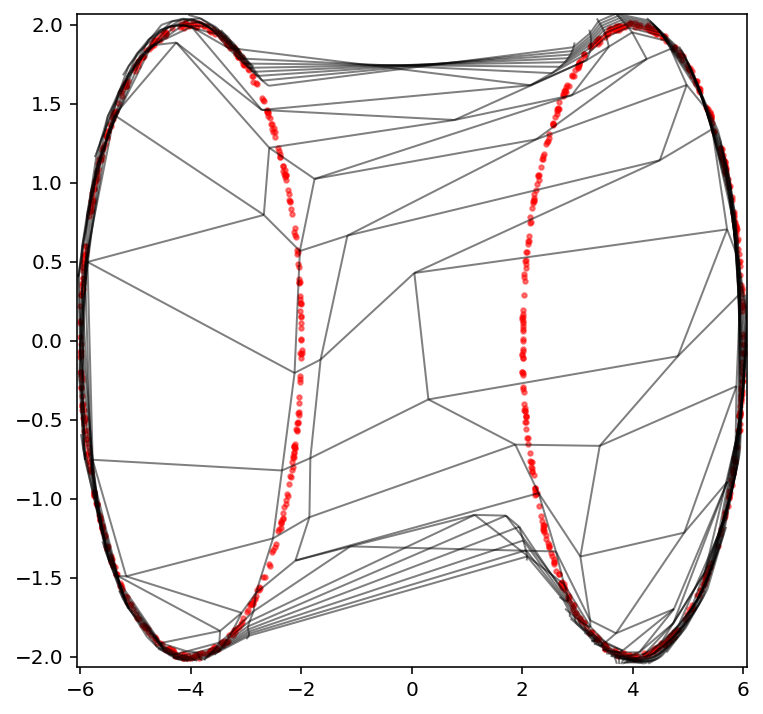

Creating directory for new run logs/test/run422
[nnest.sampler] [INFO] Num base params [2]
[nnest.sampler] [INFO] Num derived params [0]
[nnest.sampler] [INFO] Total params [2]
49.6


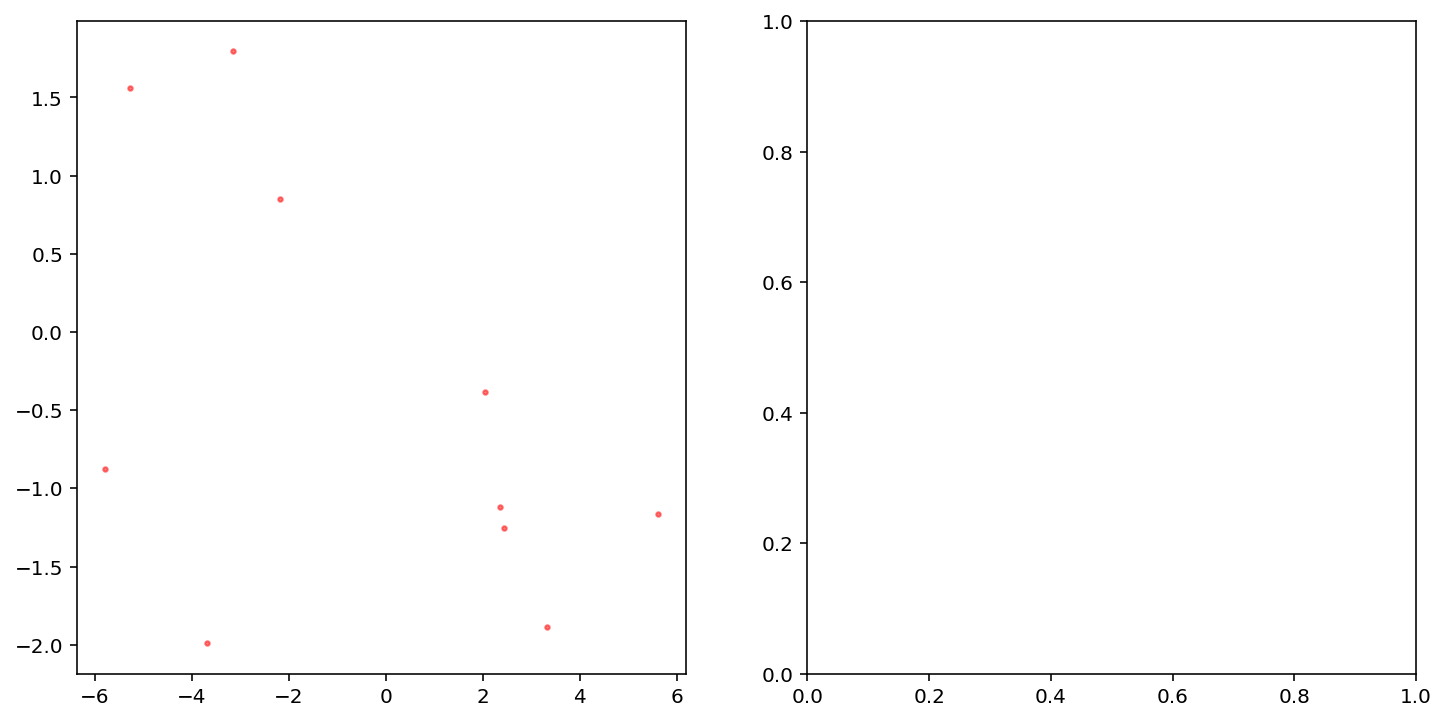

In [37]:
model = Trainer(like.x_dim, flow='spline', learning_rate=0.001)
test_rejection(like, prior, model, num_samples=10)